In [1]:
import sys
import torch
import global_variables as gv
import sys
import numpy as np
import matplotlib.pyplot as plt
import configparser
# from FACTS_Modules.Model import model_factory
from FACTS_Modules.util import string2dtype_array
from FACTS_Modules.TADA import MakeGestScore
from facts_visualizations import single_trial_plots, multi_trial_plots
import os 
import pdb
#import seaborn as sns

from sbi.inference import infer, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
import pickle
import scipy.io

from scipy.interpolate import interp1d
import re

from FACTS_Modules.TaskSFCLaw import TaskSFCLaw
from FACTS_Modules.AcousticSynthesis import AcousticSynthesis
import numpy as np
import pdb

from FACTS_Modules.LWPR_Model.lwpr import LWPR
from abc import ABC, abstractmethod

from FACTS_Modules import util
from FACTS_Modules import seutil

import pandas as pd
import seaborn as sns
from scipy import stats


In [2]:
def FACTS(theta):
    ini='DesignC_AUKF_onlinepertdelay_SBI.ini'
    gFile='GesturalScores/KimetalOnlinepert2.G'
    config = configparser.ConfigParser()
    config.read(ini)
    # print('DEBUGG')
    # Replace the parameter value from ini file
    #pdb.set_trace()
    # try:
    if theta.dim() > 1:
#             pdb.set_trace()
        #print(theta.numel())
        config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0][0].item())
        config['SensoryNoise']['Somato_sensor_scale'] = str(theta[0][1].item())
        
        config['TaskStateEstimator']['process_scale'] = str(theta[0][2].item())
        config['TaskStateEstimator']['covariance_scale'] = str(theta[0][3].item())
        config['ArticStateEstimator']['process_scale'] = str(theta[0][4].item())
        config['ArticStateEstimator']['covariance_scale'] = str(theta[0][5].item())

        config['SensoryDelay']['Auditory_delay'] = str(theta[0][6].item())
        config['SensoryDelay']['Somato_delay'] = str(theta[0][7].item())
        config['TaskStateEstimator']['cc_discount_from_delay'] = str(theta[0][8].item())
        config['ArticStateEstimator']['cc_discount_from_delay'] = str(theta[0][9].item())

        config['TaskStateEstimator']['cc_decay'] = str(theta[0][10].item())
        config['TaskStateEstimator']['cc_discount_minimum'] = str(theta[0][11].item())

#             config['TaskStateEstimator']['estimated_auditory_delay'] = str(theta[0][6].item())
#             config['ArticStateEstimator']['estimated_somat_delay'] = str(theta[0][7].item())
        
    else:
        #pdb.set_trace()
        config['SensoryNoise']['Auditory_sensor_scale'] = str(theta[0].item())
        config['SensoryNoise']['Somato_sensor_scale'] = str(theta[1].item())
        
        config['TaskStateEstimator']['process_scale'] = str(theta[2].item())
        config['TaskStateEstimator']['covariance_scale'] = str(theta[3].item())
        config['ArticStateEstimator']['process_scale'] = str(theta[4].item())
        config['ArticStateEstimator']['covariance_scale'] = str(theta[5].item())

        config['SensoryDelay']['Auditory_delay'] = str(theta[6].item())
        config['SensoryDelay']['Somato_delay'] = str(theta[7].item())
        config['TaskStateEstimator']['cc_discount_from_delay'] = str(theta[8].item())
        config['ArticStateEstimator']['cc_discount_from_delay'] = str(theta[9].item())

        config['TaskStateEstimator']['cc_decay'] = str(theta[10].item())
        config['TaskStateEstimator']['cc_discount_minimum'] = str(theta[11].item())

        # Note from Alvince, need to pass this in   
        config['TaskStateEstimator']['Auditory_delay']  = config['SensoryDelay']['Auditory_delay'] 
        config['ArticStateEstimator']['Somato_delay']  = config['SensoryDelay']['Somato_delay'] 

        # Note from Alvince, need to pass this in  for TSE    
        # config['TaskStateEstimator']['Auditory_delay']  = config['SensoryDelay']['Auditory_delay'] 
#             config['TaskStateEstimator']['estimated_auditory_delay'] = str(theta[6].item())
#             config['ArticStateEstimator']['estimated_somat_delay'] = str(theta[7].item())
    # except Exception as e:
    #     print(e)
    #     pdb.set_trace()

    model = model_factory(config)
    #pdb.set_trace()
    if 'MultTrials' in config.sections(): 
        ntrials = int(config['MultTrials']['ntrials'])
        target_noise= float(config['MultTrials']['Target_noise'])
    else: 
        ntrials = 1
        target_noise = 0

    #pdb.set_trace()
    #print(config['ArticStateEstimator']['cc_discount_from_delay'])
    gest_name = gFile.split('/')[-1].split('/')[-1]
    np.random.seed(100)
    GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)
    
    # initialize vectors to monitor position at each timestep
    buffer_size_auditory = int(float(config['SensoryDelay']['Auditory_delay']) / 5)  # default used to be 20
    buffer_size_somato = int(float(config['SensoryDelay']['Somato_delay']) / 5)
    buffer_size = max(buffer_size_auditory, buffer_size_somato)
    
    x_tilde_delaywindow = np.full([buffer_size,gv.x_dim*2], np.nan) #a new variable that state estimators will have a partial access to
    a_tilde_delaywindow = np.full([buffer_size,gv.a_dim*2], np.nan) #a new variable that state estimators will have a partial access to


    x_tilde_record = np.full([last_frm+buffer_size,gv.x_dim*2], np.nan) #changed
    somato_record = np.full([last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formant_record = np.full([last_frm+buffer_size,3], np.nan) #changed
    a_tilde_record = np.full([last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formants_produced_record = np.full([last_frm,3], np.nan)

    x_tilde_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.x_dim]) #changed
    somato_record_alltrials = np.full([ntrials,last_frm+buffer_size,gv.a_dim*2], np.nan) #changed
    formant_record_alltrials = np.full([ntrials,last_frm+buffer_size,3], np.nan) #changed
    shift_record_alltrials = np.full([ntrials,last_frm+buffer_size,3], np.nan) #changed
    formants_produced_record_alltrials = np.full([ntrials,last_frm,3], np.nan)

    
    a_tilde_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    a_dot_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    a_dotdot_record_alltrials = np.empty([ntrials,last_frm+buffer_size,gv.a_dim])
    predict_formant_record_alltrials = np.empty([ntrials,last_frm+buffer_size,3])

    #Check if catch trials (no perturbation) are specified in the config file
    if 'CatchTrials' in config.keys():
        catch_trials = string2dtype_array(config['CatchTrials']['catch_trials'], dtype='int')
        catch_types = string2dtype_array(config['CatchTrials']['catch_types'], dtype='int')
        if len(catch_trials) != len(catch_types):
            raise Exception("Catch trial and catch type lengths not matching, please check the config file.")
    else: catch_trials = np.array([])

    #Run FACTS for each trial
    for trial in range(ntrials):
        #print("trial:", trial)
        #Gestural score (task)
        GestScore, ART, ms_frm, last_frm = MakeGestScore(gFile,target_noise)         #this is similar with MakeGest in the matlab version

        # initial condition
        x_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_delaywindow[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        x_tilde_record[0] = string2dtype_array(config['InitialCondition']['x_tilde_init'],'float')
        a_tilde_record[0] = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        a_actual = string2dtype_array(config['InitialCondition']['a_tilde_init'],'float')
        model.artic_sfc_law.reset_prejb() #save the initial artic-to-task model.
        all_adotdot = []

        if trial in catch_trials: catch = catch_types[np.where(catch_trials==trial)[0][0]]
        else: catch = False
        #print("catch:", catch)
        
        for i_frm in range(last_frm): #gotta change this hardcoded number to aud delay later
            #model function runs FACTS by each frame
            x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced = model.run_one_timestep(x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, GestScore, ART, ms_frm, i_frm, trial, catch)
            if (formants_produced == -1).all():
                formants_produced_record[i_frm:] = [-1, -1, -1]
                a_tilde_record[i_frm:] = np.tile(-10000, 12)
                x_tilde_record[i_frm:] = np.tile(-10000, 14)
                break
            else:
                a_tilde_record[i_frm+1] = a_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                x_tilde_record[i_frm+1] = x_tilde_delaywindow[0,:] #0 is always the most recnet current frame
                formants_produced_record[i_frm] = formants_produced 
                all_adotdot.append(adotdot)
            


        # x1_pred = np.array(model.task_state_estimator.all_internal_x1_prediction)
        # plt.plot(range(x1_pred.shape[0]), x1_pred)
        #pdb.set_trace()
        #P_over_time = np.array(model.task_state_estimator.all_P)
        #plt.plot(P_over_time)
        #plt.show()

        predict_formant_record_alltrials[trial,] = y_hat
        formants_produced_record_alltrials[trial,] = formants_produced_record
        
        a_tilde_record_alltrials[trial,] = a_tilde_record[:,0:gv.a_dim]
        #a_dot_record[trial, ] = a_tilde[gv.a_dim:]
        x_tilde_record_alltrials[trial,] = x_tilde_record[:,0:gv.x_dim]
        formant_record_alltrials[trial,] = formant_record
        somato_record_alltrials[trial,] = somato_record
        
        model.task_state_estimator.update(catch)

        plot_trial = False 
        if plot_trial:
            plt.figure()
            single_trial_plots('baseline', 
                                    trial, a_tilde_record_alltrials, 
                                    a_tilde_record_alltrials, formant_record_alltrials, 
                                    predict_formant_record_alltrials, x_tilde_record_alltrials, 
                                    [ini, gFile], formants_produced_record_alltrials)
            #pdb.set_trace() # Test if we can print model.
            plt.figure()
            all_Y = np.array(model.task_state_estimator.all_Y)
            plt.plot(all_Y[:,0,:])
            plt.title('Y from TSE Auditory Prediction')

            plt.figure()
            all_y = np.array(model.task_state_estimator.all_y)
            plt.plot(all_y[:,0])
            plt.title('y from TSE Auditory Prediction')
            plt.show()

            #pdb.set_trace()
            a2t_xtilde = np.array(model.task_state_estimator.artic_to_task_xtilde)
            plt.plot(a2t_xtilde)
            plt.title('artic_to_task_xtilde')
            plt.show()

            plt.figure()
            tse_delay_y = np.array(model.task_state_estimator.all_delay_y)
            plt.plot(tse_delay_y[:,0])
            plt.title('tse_delay_y')
            plt.show()

            plt.figure()
            all_formant_with_noise = np.array(model.task_state_estimator.all_formant_with_noise)
            plt.plot(all_formant_with_noise[:,0])
            plt.title('all_formant_with_noise')
            plt.show()


            plt.figure()
            all_X1 = np.array(model.task_state_estimator.all_X1)
            plt.plot(all_X1[:,:,0])
            plt.title('X1 into TSE Aud Predict')
            plt.show()

            plt.figure()
            all_adotdot = np.array(all_adotdot)
            print(all_adotdot.shape)
            plt.plot(all_adotdot)
            plt.title('adotdot')
            plt.show()

            plt.show()

        #print(f"formant_record_alltrials {formant_record_alltrials}")
        #print(f"formants_produced_record_alltrials {formants_produced_record_alltrials}")
        del x_tilde_record
        del a_tilde_record
        del formant_record
        del somato_record
    #pdb.set_trace()
    return torch.from_numpy( formants_produced_record_alltrials[:,:,0].squeeze() )



def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


# Model.py runs all major FACTS modules. Modules that are 
# carried out in each time step are listed in the method 
# "run_one_timestep." model_factory builds FACTS based on 
# the model architecture specified in config files. 

# Under "Hierarchical_xdotdot," for example, the task 
# state estimator type is defined as lwpr. 

def model_factory(config):
    if 'ModelArchitecture' in config.keys():
        if config['ModelArchitecture']['architecture'] == 'classic': return Model(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical': return Hierarchical_Model(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical_articsfcupdate': return Hierarchical_ArticSFCUpdate_Model(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical_xdotdot': return Hierarchical_xdotdot(config)
        if config['ModelArchitecture']['architecture'] == 'hierarchical_JacUpdateDebug': return Hierarchical_JacUpdateDebug(config)
    return Model(config)


# parent class
class Model():
    def __init__(self,model_configs):
        self.task_sfc_law = TaskSFCLaw()
        self.artic_sfc_law = self.artic_sfc_law_factory(model_configs['ArticSFCLaw'])
        self.artic_kinematics = self.artic_kinematics_factory(model_configs)
        self.acoustic_synthesis = AcousticSynthesis(model_configs['AcousticSynthesis'])
        self.auditory_perturbation = self.auditory_perturbation_factory(model_configs)
        self.sensory_system_noise = self.sensory_system_noise_factory(model_configs)
        self.sensory_system_delay = self.sensory_system_delay_factory(model_configs)
        R_Auditory = self.sensory_system_noise.get_R_Auditory()
        R_Somato = self.sensory_system_noise.get_R_Somato()
        self.artic_state_estimator = self.ase_factory(model_configs,R_Auditory,R_Somato)
        self.task_state_estimator = self.tse_factory(model_configs['TaskStateEstimator'],R_Auditory,R_Somato)
        #self.state_estimator = self._state_estimator_factory(model_configs,R_Auditory,R_Somato)
        
    def run_one_timestep(self, prev_x_tilde, prev_a_tilde, prev_a_actual, GestScore, ART, ms_frm,i_frm, trial, catch):
        xdotdot, PROMACT = self.task_sfc_law.run(prev_x_tilde,GestScore,i_frm)
        adotdot = self.artic_sfc_law.run(xdotdot, prev_a_tilde,ART,i_frm,PROMACT,ms_frm)
        a_actual = self.artic_kinematics.run(prev_a_actual,adotdot,ms_frm)
        formants = self.acoustic_synthesis.run(a_actual)
        formants_shifted = self.auditory_perturbation.run(formants,i_frm,trial,catch)
        formants_noise, a_noise = self.sensory_system_noise.run(formants_shifted,a_actual)
        a_tilde, y_hat = self.artic_state_estimator.run(prev_a_tilde,adotdot,formants_noise,a_noise,ms_frm,i_frm,catch)
        x_tilde = self.task_state_estimator.run(a_tilde)

        return x_tilde, a_tilde, a_actual, formants, formants_noise, adotdot, y_hat
        
    # Factory methods
    def artic_sfc_law_factory(self,configs):
        model_type = configs['model_type']
        #print('Artic SFC Law Model Type: ', model_type)
        if model_type == 'lwpr':
            from FACTS_Modules.ArticSFCLaw import ArticSFCLaw_LWPR_noupdate
            artic_sfc_law = ArticSFCLaw_LWPR_noupdate(configs)
        return artic_sfc_law
    
    def artic_kinematics_factory(self,model_configs):
        if 'ArticKinematics' in model_configs.sections():
            from FACTS_Modules.ArticKinematics import ArticKinematics_Noise
            artic_kinematics = ArticKinematics_Noise(model_configs['ArticKinematics'])
        else:
            from FACTS_Modules.ArticKinematics import ArticKinematics
            artic_kinematics = ArticKinematics()
        return artic_kinematics
    
    def sensory_system_noise_factory(self,model_configs):
        if 'SensoryNoise' in model_configs.sections():
            from FACTS_Modules.SensorySystemNoise import SensorySystemNoise
            sensory_system_noise = SensorySystemNoise(model_configs['SensoryNoise'])
        else:
            from FACTS_Modules.SensorySystemNoise import SensorySystemNoise_None
            sensory_system_noise = SensorySystemNoise_None()
        return sensory_system_noise

    def sensory_system_delay_factory(self,model_configs):
        if 'SensoryDelay' in model_configs.sections():
            from FACTS_Modules.SensorySystemDelay import SensorySystemDelay
            sensory_system_delay = SensorySystemDelay(model_configs['SensoryDelay'])
        return sensory_system_delay

    def auditory_perturbation_factory(self,model_configs):
        if 'AudPerturbation' in model_configs.sections():
            from FACTS_Modules.AuditoryPerturbation import AuditoryPerturbation
            auditory_perturbation = AuditoryPerturbation(model_configs['AudPerturbation'])
        else:
            from FACTS_Modules.AuditoryPerturbation import AuditoryPerturbation_None
            auditory_perturbation = AuditoryPerturbation_None()
        return auditory_perturbation
    
    def ase_factory(self,model_configs,R_Auditory,R_Somato):
        if 'ArticStateEstimator' in model_configs.sections():
            model_type = model_configs['ArticStateEstimator']['model_type']
            if model_type == 'lwpr':
                from FACTS_Modules.ArticStateEstimator import ASE_UKF_Classic
                artic_state_estimator = ASE_UKF_Classic(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)
        return artic_state_estimator
    
    def tse_factory(self,tse_configs,R_Auditory,R_Somato):
        model_type = tse_configs['model_type']
        #print('Task State Estimator Model Type: ', model_type)
        if model_type == 'lwpr':
            from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Classic
            task_state_estimator = TSE_LWPR_Classic(tse_configs)
        return task_state_estimator
    
class Hierarchical_Model(Model):
    def ase_factory(self,model_configs,R_Auditory,R_Somato):
        if 'ArticStateEstimator' in model_configs.sections():
            model_type = model_configs['ArticStateEstimator']['model_type']
            if model_type == 'lwpr':   
                artic_state_estimator = ASE_UKF_Hier_NoiseEst(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)             
                # if 'Somato_sensor_scale_est' in model_configs['ArticStateEstimator']:
                #     # from FACTS_Modules.ArticStateEstimator import ASE_UKF_Hier_NoiseEst
                #     artic_state_estimator = ASE_UKF_Hier_NoiseEst(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)
                #     #print('got the right ASE')
                # else:    
                #     # from FACTS_Modules.ArticStateEstimator import ASE_UKF_Hier
                #     artic_state_estimator = ASE_UKF_Hier(model_configs['ArticStateEstimator'],R_Auditory,R_Somato)
        return artic_state_estimator
    
    def tse_factory(self,tse_configs,R_Auditory,R_Somato):
        #print('Inside the tse factory')
        model_type = tse_configs['model_type']
        #print('Task State Estimator Model Type: ', model_type)
        if model_type == 'lwpr':
            from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Hier
            task_state_estimator = TSE_LWPR_Hier(tse_configs,R_Auditory,R_Somato)
        return task_state_estimator
    
    def run_one_timestep(self, prev_x_tilde, prev_a_tilde, prev_a_actual, GestScore, ART, ms_frm,i_frm, trial, catch):
        xdotdot, PROMACT = self.task_sfc_law.run(prev_x_tilde,GestScore,i_frm)
        adotdot = self.artic_sfc_law.run(xdotdot, prev_a_tilde,ART,i_frm,PROMACT,ms_frm)
        a_actual = self.artic_kinematics.run(prev_a_actual,adotdot,ms_frm)
        formants = self.acoustic_synthesis.run(a_actual)
        formants_shifted = self.auditory_perturbation.run(formants,i_frm,trial,catch)
        formants_noise, a_noise = self.sensory_system_noise.run(formants_shifted,a_actual)
        a_tilde, a_hat = self.artic_state_estimator.run(prev_a_tilde,adotdot,a_noise,ms_frm,i_frm,catch)
        x_tilde = self.task_state_estimator.run(a_tilde,formants_noise,i_frm,catch)
        return x_tilde, a_tilde, a_actual, formants, formants_noise, adotdot

        

class Hierarchical_xdotdot(Hierarchical_Model):
    def tse_factory(self,tse_configs,R_Auditory,R_Somato):
        model_type = tse_configs['model_type']
        #print('Task State Estimator Model Type: ', model_type)
        if model_type == 'lwpr':
            task_state_estimator = TSE_LWPR_Hier_xdotdot(tse_configs,R_Auditory,R_Somato)
            # if 'Auditory_sensor_scale_est' in tse_configs:
            #     # from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Hier_NoiseEst
            #     task_state_estimator = TSE_LWPR_Hier_NoiseEst(tse_configs,R_Auditory,R_Somato)
            #     #print('got the right TSE')
            # else:  
            #     # from FACTS_Modules.TaskStateEstimator import TSE_LWPR_Hier_xdotdot
            #     task_state_estimator = TSE_LWPR_Hier_xdotdot(tse_configs,R_Auditory,R_Somato)
        return task_state_estimator
     
    def run_one_timestep(self, x_tilde_delaywindow, a_tilde_delaywindow, prev_a_actual, somato_record, formant_record, GestScore, ART, ms_frm,i_frm, trial, catch):
        xdotdot, PROMACT = self.task_sfc_law.run(x_tilde_delaywindow[0],GestScore,i_frm)
        adotdot = self.artic_sfc_law.run(xdotdot, a_tilde_delaywindow[0],ART,i_frm,PROMACT,ms_frm)
        if type(adotdot) != np.ndarray or any(np.isnan(adotdot)):
            formants_produced = np.array([-1, -1, -1], dtype= np.float32)
            a_actual = [-10000,-10000,-10000]
            y_hat = np.array([-1, -1, -1], dtype= np.float32)
            return x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced

        try:
            a_actual = self.artic_kinematics.run(prev_a_actual,adotdot,ms_frm)
            #print("a_actual",a_actual)
            formants = self.acoustic_synthesis.run(a_actual)
            #print("Maeda output",formants)
            formants_shifted = self.auditory_perturbation.run(formants,i_frm,trial,catch)
            formants_noise, somato_noise = self.sensory_system_noise.run(formants_shifted,a_actual)
            formants_noise, somato_noise, formant_record, somato_record = self.sensory_system_delay.run(ms_frm, i_frm,formants_noise,somato_noise,formant_record,somato_record)
            prev_a_tilde = a_tilde_delaywindow[0]
            
            #print("x_tilde",x_tilde_record[i_frm])
            #print("x_tilde",x_tilde_record[119])
            a_tilde, a_hat = self.artic_state_estimator.run(a_tilde_delaywindow,adotdot,somato_noise,ms_frm,i_frm,catch)
            #pdb.set_trace()
            #print("i_frm",i_frm)
            #print("atilde",a_tilde)
            x_tilde, y_hat = self.task_state_estimator.run(a_tilde_delaywindow,formants_noise,i_frm,catch,xdotdot)
            #print('y_hat', y_hat)

            #print("form_hat",y_hat_record[i_frm+2])
            #a_tilde_record[i_frm+1] = a_tilde 
            #x_tilde_record[i_frm+1] = x_tilde
            a_tilde_delaywindow = np.insert(a_tilde_delaywindow[0:-1,:],0,a_tilde,0) #add the most recent frame to 0 and remove the oldest frame.
            x_tilde_delaywindow = np.insert(x_tilde_delaywindow[0:-1,:],0,x_tilde,0)
            #print("estimator end----------------------------------------------------------------------------------------------")

            formants_produced = formants
            return x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced
    
        except Exception as e:
            print(e)
            formants_produced = np.array([-1, -1, -1], dtype= np.float32)
            a_actual = [-10000,-10000,-10000]
            y_hat = np.array([-1, -1, -1], dtype= np.float32)
            return x_tilde_delaywindow, a_tilde_delaywindow, a_actual, somato_record, formant_record, adotdot, y_hat, formants_produced

class TaskStateEstimator(ABC):
    def update(self,catch):
        print('TSE Update not implemented')

class TSEClassicInterface():
    @abstractmethod
    def run(self,a_tilde):
        raise NotImplementedError
        
class TSEHierInterface():
    @abstractmethod
    def run(self,a_tilde,formants):
        raise NotImplementedError
        
class TSE_LWPR(TaskStateEstimator):
    def __init__(self,tse_configs):
        self.Taskmodel = LWPR(tse_configs['Task_model_path'])
        self.Taskmodel.init_lambda = float(tse_configs['lwpr_init_lambda'])
        self.Taskmodel.tau_lambda = float(tse_configs['lwpr_tau_lambda'])
        self.Taskmodel.final_lambda = float(tse_configs['lwpr_final_lambda'])
    
#Task Estimator in Parrell et al. (2019)
#which is a simple transformation of the artic state
class TSE_LWPR_Classic(TSE_LWPR,TSEClassicInterface):
    def __init__(self,tse_configs):
        super().__init__(tse_configs)
    def run(self,a_tilde):
        jac = self.Taskmodel.predict_J(a_tilde[0:gv.a_dim])
        x_tilde = np.append(jac[0],np.matmul(jac[1],a_tilde[gv.a_dim:2*gv.a_dim]))
        #pdb.set_trace()
        #print("xtilde", x_tilde)
        return x_tilde

#Task Estimator that receives auditory feedback
#and uses UKF (or AUKF). However, this task
#estimator does not use the task efference copy (xdotdot)
class TSE_LWPR_Hier(TSE_LWPR,TSEHierInterface):
    def __init__(self,tse_configs,R_Auditory,R_Somato):
        super().__init__(tse_configs)
        self.R = np.diag(R_Auditory)

        #these are the parameters used in the paper simulations, read from config file
        process_scale = float(tse_configs['process_scale'])
        covariance_scale = float(tse_configs['covariance_scale'])
        # prepare class data
        t_step = 1
        tempQ_AA = 1*np.eye(gv.x_dim)*t_step**4; #pos-pos covariance
        tempQ_AADOT = 0*np.eye(gv.x_dim)*t_step**3; #pos-vel covariance
        tempQ_ADOTADOT = 1*np.eye(gv.x_dim)*t_step**2 #vel-vel covariance
        self.Q=1e0*process_scale*np.hstack((np.vstack((tempQ_AA,tempQ_AADOT)),np.vstack((tempQ_AADOT,tempQ_ADOTADOT))))# process noise covariance, scaled by plant noise scale factor
        self.feedbackType = tse_configs['feedback_type']

        # create state covariance matrix P
        self.P = covariance_scale*np.eye(gv.x_dim*2);

        #self.nulltaskmodel = LWPR(tse_configs['Task_model_path']) #3/17/22 change
        #Weights and coefficient
        alpha = 1e-3#1e-3
        beta = -1 #-1#-18.2 #-17.6 # - 166000 # - 166668  #default, tunable
        # alpha=1e-3;                                 %default, tunable
        #alpha=[1e-3 1];                                 %tunable
        #alpha=1e-3
        #% alpha=[1 1];                                 %for 3rd order symmetric
        #ki= 3-(gv.x_dim*2)                                #tunable
        ki= -11#-11                              #default, tunable        
        lam=(alpha**2)*((gv.x_dim*2)+ki)-(gv.x_dim*2)                    #scaling factor
        c=(gv.x_dim*2)+lam                                 #scaling factor
        self.Wm=np.append(lam/c,np.zeros(2*(gv.x_dim*2))+0.5/c)           #weights for means
        #Wm=np.array([lam/c 0.5/c+np.zeros(2*L)])           #weights for means
        #Wm=np.array([lam/c 0.5/c+np.zeros(2*L)])           #weights for means
        self.Wc=self.Wm
        self.Wc[0]=self.Wc[0]+(1-alpha**2+beta)         #weights for covariance        
        self.c=np.sqrt(c)
        
        self.senmem = []
        if tse_configs['learn'] == 'True':
            self.learn = True
        else: 
            self.learn = False
        self.taskmem = []
        self.Aud_model = LWPR(tse_configs['Formant_model_path'])
        self.Aud_model.init_lambda = float(tse_configs['lwpr_init_lambda'])
        self.Aud_model.tau_lambda = float(tse_configs['lwpr_tau_lambda'])
        self.Aud_model.final_lambda = float(tse_configs['lwpr_final_lambda'])

        self.defQ = self.Q
        self.defR = self.R
        self.defP = self.P

        self.APET = float(tse_configs['F1_Prediction_Error_Threshold'])
        
        if tse_configs['AUKF'] == 'True':
            self.AUKF = True
            self.AUKFmultFactor = string2dtype_array(tse_configs['AUKFmultFactor'], 'float32')
        else: 
            self.AUKF = False

        # self.artic_to_task_xtilde = []

    def run(self,a_tilde,formant_noise,i_frm,catch):
        
        jac = self.Taskmodel.predict_J(a_tilde[0:gv.a_dim])
        x_tilde = np.append(jac[0],np.matmul(jac[1],a_tilde[gv.a_dim:2*gv.a_dim]))
        # self.artic_to_task_xtilde.append(x_tilde)

        X=seutil.sigmas(x_tilde,self.P,self.c) #sigma points around x tilde
        if type(X) != np.ndarray:
            pdb.set_trace()

        x1,X1,P1,X2 = self.TaskStatePredict(X,self.Wm,self.Wc,gv.x_dim*2,self.Q) #transformation of x_tilde (propagation)

        if self.feedbackType == 'nofeedback' or catch or i_frm < 10:
            x = x1
            self.P = P1
        else:
            Y,y=seutil.TaskAuditoryPrediction(self.Aud_model,X1,self.Wm)
            z = formant_noise
            #print("predict: ", y)
            #print("actual: ", z)
            #Y1 = trnasofrmed deviations, P = transformed covariance
            Y1,self.P = seutil.transformedDevandCov(Y,y,self.Wc,self.R)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

            #StateCorrection and Eq 5 and 6
            DeltaX, DeltaCov = seutil.StateCorrection(X2,self.Wc,Y1,self.P,z,y)
             
            #StateUpdate Eq 7, 
            x = x1 + DeltaX
            # print('internal TSE state estimate ', x1)

            # print(f'i_frm= {i_frm}, DeltaX =  {DeltaX}')
            self.P= P1 - DeltaCov #covariance update

            self.senmem, self.taskmem = seutil.auderror(y,z,self.senmem,x1,self.taskmem,x,a_tilde,self.APET)
            if self.learn: # current version has no online compensation during adapt
                x = x1
                self.P = P1

        x_tilde = x
        #x_hat = x1
        return x_tilde
    
    def TaskStatePredict(self,X,Wm,Wc,n,R):
        #Unscented Transformation for process model
        #Input:
        #        X: sigma points
        #       Wm: weights for mean
        #       Wc: weights for covraiance
        #        n: numer of outputs of f
        #        R: additive covariance
        #        u: motor command
        #Output:
        #        y_tmean: transformed mean.
        #        Y: transformed sampling points
        #        P: transformed covariance
        #       Y1: transformed deviations
        
        L=X.shape[1]
        y_tmean=np.zeros(n)
        Y=np.zeros([n,L])
        Y1 = np.zeros([n,L])
        for k in range(L):
            #jac = Taskmodel.predict_J(X[0:gv.a_dim,k])
            #Y[:,k] = np.append(jac[0],np.matmul(jac[1],X[gv.a_dim:2*gv.a_dim,k]))
            Y[:,k] = X[0:gv.x_dim*2,k] # 1 to 1 relationship, because this is just getting unscented transformation.
            y_tmean=y_tmean+Wm[k]*Y[:,k]
            #print(Wm[k])
            #print(Y[:,k])
            #print(Wm[k]*Y[:,k])
        
        Y1,P = seutil.transformedDevandCov(Y,y_tmean,Wc,R)
        return y_tmean,Y,P,Y1 
        
    def update(self,catch):
        if self.learn and not catch == 2:
            #self.Aud_model = seutil.UpdateAuditoryPrediction(self.Aud_model,self.taskmem,self.senmem)
            self.taskmem, self.Taskmodel = seutil.UpdateTaskPrediction(self.Taskmodel,self.taskmem,self.senmem)
            #print(Taskmodel.predict(np.array([0.0631606,-0.13590163,0.0706008,0.04309455,-0.00238945,0.00098181])))
            #print(len(self.senmem))
            #self.senmem, self.Aud_model = seutil.UpdateSensoryPrediction('audOnly',self.Aud_model,0,self.senmem) 
            #print(self.Aud_model.predict(np.array([15.78746351,14.68617247,18.93449447,17.52760635,29.64618912,14.33349587,13.04996568])))     
        
        self.taskmem = []
        self.senmem = []

#Task Estimator from Kim et al. (in review).
#Receives auditory feedback and uses UKF (or AUKF). 
#This task estimator also receives efference copy (xdotdot)

class TSE_LWPR_Hier_xdotdot(TSE_LWPR_Hier):
    def __init__(self,tse_configs,R_Auditory,R_Somato):
        super().__init__(tse_configs,R_Auditory,R_Somato)
        self.TSP = []
        self.all_internal_x1_prediction = []
        self.all_P = []
        self.all_Y = []
        self.all_y = []
        self.all_X1 = []
        self.artic_to_task_xtilde = []
        self.all_formant_with_noise = []
        self.all_delay_y = []

        for i in range(gv.x_dim):
            self.TSP.append(LWPR(tse_configs['TSP_model_path']))
            self.TSP[i].init_lambda = float(tse_configs['lwpr_init_lambda'])
            self.TSP[i].tau_lambda = float(tse_configs['lwpr_tau_lambda'])
            self.TSP[i].final_lambda = float(tse_configs['lwpr_final_lambda'])
            

        #self.Aud_delay = int(float(tse_configs['estimated_auditory_delay']) / 5) #20 #later make this separate setting in the config file
        self.Aud_delay = int(float(tse_configs['Auditory_delay']) / 5) 
        #print(f'self.Aud_delay {self.Aud_delay}')
        self.cc_discount_from_delay = float(tse_configs['cc_discount_from_delay'])
        self.cc_decay = float(tse_configs['cc_decay'])
        self.cc_discount_minimum = float(tse_configs['cc_discount_minimum'])
        #should be able to be configured differently from the real sensory delay 

        #self.X2_record = np.full([self.Aud_delay,gv.x_dim*2,29],np.nan)
        #self.P1_record = np.full([self.Aud_delay,gv.x_dim*2,gv.x_dim*2],np.nan)
        self.h_delay = np.zeros(self.Aud_delay)
        self.h_delay[-1] = 1

        self.Y_record = np.full([self.Aud_delay,3,29],np.nan) #last comment 10/27 maybe this is a bad idea
        #better idea may be that estimators also get a_record
        # and that they just simply access a_record[i_frm] if i_frm >10 
        # if so you can use a_record[i_frm-10] to make the prediction 
        # which woiuld line up temporally with the somato feedback
        self.X2_record = np.full([self.Aud_delay,gv.x_dim*2,29],np.nan)
        self.P1_record = np.full([self.Aud_delay,gv.x_dim*2,gv.x_dim*2],np.nan)

        #np.vstack((a,b[None]))
        #the current x_tilde and a_tilde should always be up to date 
        self.y_record = np.full([self.Aud_delay,3],np.nan)
        self.K = None

    def run(self,a_tilde_delaywindow,formant_noise,i_frm,catch,xdotdot):
        a_tilde = a_tilde_delaywindow[0] # most recent frame, since this is an internal estimate process
        jac = self.Taskmodel.predict_J(a_tilde[0:gv.a_dim])
        x_tilde = np.append(jac[0],np.matmul(jac[1],a_tilde[gv.a_dim:2*gv.a_dim]))
        self.artic_to_task_xtilde.append(x_tilde)

        #print(x_tilde)
        #print(self.Taskmodel.predict(a_tilde[0:gv.a_dim]))

        X=seutil.sigmas(x_tilde,self.P,self.c) #sigma points around x tilde
        #pdb.set_trace()
        #print(f"sigmas {X}")
        if type(X) != np.ndarray: # Cholesky failed so move on to next trial
            return None, None
        x1,X1,P1,X2 = self.TaskStatePredict(X,self.Wm,self.Wc,gv.x_dim*2,self.Q, xdotdot) #transformation of x_tilde (propagation)
        self.all_X1.append(X1)
        self.all_internal_x1_prediction.append(x1)

        Y,y=seutil.TaskAuditoryPrediction(self.Aud_model,X1,self.Wm)
        self.all_Y.append(Y)
        self.all_y.append(y)
        z = formant_noise 
        self.all_formant_with_noise.append(z) 
        #print("KTRY",self.Aud_model.predict(x_tilde[0:gv.x_dim]))

   
        #self.X2_record = np.vstack((X2[None],self.X2_record[0:-1,:]))
        #self.P1_record = np.vstack((P1[None],self.P1_record[0:-1,:]))
        self.Y_record = np.vstack((Y[None],self.Y_record[0:-1,:]))
        self.y_record = np.vstack((y[None],self.y_record[0:-1,:]))
        #pdb.set_trace()
        
        if np.isnan(z[0]):
            x = x1
            self.P = self.defP
            #y = self.y_record[0,] #Just nan since the prediction was not used, but will be used in the future.
        else:


            #print("predict: ", y)
            #print("actual: ", z)
            #print(self.P)
            #Y1 = trnasofrmed deviations, P = transformed covariance
            #y = self.y_record[i_frm] #Retrieving the prediction made a while ago.
            delay_y = np.matmul(np.transpose(self.h_delay),self.y_record)
            delay_Y = np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0])[0]
            #delay_X2 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.X2_record,axes=[1,0])[0]
            #delay_P1 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.P1_record,axes=[1,0])[0]

            self.all_delay_y.append(delay_y)
            #print(self.R)
            Y1,self.P = seutil.transformedDevandCov(delay_Y,delay_y,self.Wc,self.R)
            self.all_P.append(self.P)
            #Y1,self.P = seutil.transformedDevandCov(self.Y_record[i_frm],y,self.Wc,self.R*4.5)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)
            obscov = self.P
            #pdb.set_trace()
            #StateCorrection and Eq 5 and 6
            DeltaX, DeltaCov = seutil.StateCorrectionForDelay(X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay)

            # if i_frm < 35:
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay)
            # else:
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay, self.K)

            if i_frm > 40: # Alvince Jan 23rd, 2020. This is a test for simulated perturbation detection
                self.cc_discount_from_delay = self.cc_discount_from_delay * self.cc_decay
                #print(self.cc_discount_from_delay)
                if self.cc_discount_from_delay < self.cc_discount_minimum:
                        self.cc_discount_from_delay = self.cc_discount_minimum


            #StateUpdate Eq 7, 
            x = x1 + DeltaX
            #print(f'{i_frm} internal TSE state estimate ', x1)
            #print('final x_tilde =  ', x)

            # print(f'i_frm= {i_frm}, DeltaX =  {DeltaX}')
            #print(f'i_frm {i_frm}, TSE_LWPR_Hier_xdotdot: z - delay_y = {z - delay_y}')
            self.P= P1 - DeltaCov#covariance update
            #$print(self.R)
            if self.learn: # current version has no online compensation during adapt
                x = x1
                
                residual = (z-delay_y)
                eps = np.matmul(np.matmul(np.transpose(residual),np.linalg.inv(obscov)),residual)
                #print(eps)
                if eps>50 and self.AUKF:
                    #print("AUKF on")
                    DeltaX, DeltaCov = seutil.StateCorrection(X2*self.AUKFmultFactor[0],self.Wc,Y1,obscov,z,delay_y) #commented 052522
                    self.Q = self.defQ*self.AUKFmultFactor[1] #commented 052522
                    self.P = self.defP*self.AUKFmultFactor[2] #commented 052522

                else:
                    #print("AUKF off")
                    self.P = self.defP
                    self.R = self.defR
                    self.Q = self.defQ

                self.senmem, self.taskmem = seutil.auderror(y,z,self.senmem,x1,self.taskmem,x1+DeltaX,a_tilde,self.APET)

        x_tilde = x
        
        return x_tilde, z, 
        
    def TaskStatePredict(self,X,Wm,Wc,n,R,u):
        #Unscented Transformation for process model
        #Input:
        #        X: sigma points
        #       Wm: weights for mean
        #       Wc: weights for covraiance
        #        n: numer of outputs of f
        #        R: additive covariance
        #        u: motor command
        #Output:
        #        y_tmean: transformed mean.
        #        Y: transformed sampling points
        #        P: transformed covariance
        #       Y1: transformed deviations
        
        L=X.shape[1]
        y_tmean=np.zeros(n)
        Y=np.zeros([n,L])
        Y1 = np.zeros([n,L])
        temp = np.zeros([gv.x_dim,2])
        for k in range(L): 
            #sol2 = solve_ivp(fun=lambda t, y: ode45_dim6(t, y, u), t_span=[0, ms_frm/1000], y0=X[:,k], method='RK45', dense_output=True, rtol=1e-13, atol=1e-22)     
            for z in range(gv.x_dim):
                temp[z,0:2] = self.TSP[z].predict(np.array([X[z,k],X[z+gv.x_dim,k],u[z]]))
                Y[z,k] = temp[z,0]
                #temp[z,0:2] = TSPmodel[0].predict(np.array([X[z,k],X[z+gv.x_dim,k],u[z]]))
                Y[z+gv.x_dim,k] = temp[z,1]
    
    
            y_tmean=y_tmean+Wm[k]*Y[:,k]
            #print(Wm[k])
            #print(Y[:,k])
            #print(Wm[k]*Y[:,k])
            
        Y1,P = seutil.transformedDevandCov(Y,y_tmean,Wc,R)
        return y_tmean,Y,P,Y1

class TSE_LWPR_Hier_NoiseEst(TSE_LWPR_Hier_xdotdot):
    def __init__(self,tse_configs,R_Auditory,R_Somato):
        super().__init__(tse_configs,R_Auditory,R_Somato)
        
        Auditory_sensor_scale_est = float(tse_configs['Auditory_sensor_scale_est'])
        nAuditory = int(tse_configs['nAuditory'])
        norms_Auditory = util.string2dtype_array(tse_configs['norms_Auditory'], float)
        norms_AADOT = util.string2dtype_array(tse_configs['norms_AADOT'], float)

        R_Auditory_est = 1e0*Auditory_sensor_scale_est*np.ones(nAuditory)*norms_Auditory
        self.R = np.diag(R_Auditory_est)
        self.defR = self.R

class ASEClassicInterface:
    @abstractmethod
    def run(self, a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch):
        raise NotImplementedError
class ASEHierInterface:
    @abstractmethod
    def run(self,a_tilde,adotdot,a_noise,ms_frm,i_frm,catch):
        raise NotImplementedError

class ArticStateEstimator(ABC):
    def update(self):
        print('ASE Update not implemented')

class ASE_Pass(ArticStateEstimator):
    def run(self, a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch):
        a_tilde = a_noise
        a_hat = np.zeros(gv.a_dim*2)
        return a_tilde, a_hat
    
class ASE_Pass_Classic(ASE_Pass,ASEClassicInterface):
    def run(self, a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch):
        return super().run(a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch)
        
class ASE_Pass_Hier(ASE_Pass,ASEHierInterface):
    def run(self,a_tilde,adotdot,a_noise,ms_frm,i_frm,catch):
        formants = [1000,2000,4000]
        a_tilde, a_hat = super().run(a_tilde,adotdot,formants,a_noise,ms_frm,i_frm,catch)
        return a_tilde
    
class ASE_UKF(ArticStateEstimator):
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        #these are the parameters used in the paper simulations, read from config file
        process_scale = float(articstateest_configs['process_scale'])
        covariance_scale = float(articstateest_configs['covariance_scale'])
        # prepare class data
        t_step = 1
        tempQ_AA = 1*np.eye(gv.a_dim)*t_step**4; #pos-pos covariance
        tempQ_AADOT = 0*np.eye(gv.a_dim)*t_step**3; #pos-vel covariance
        tempQ_ADOTADOT = 1*np.eye(gv.a_dim)*t_step**2 #vel-vel covariance
        self.Q=1e0*process_scale*np.hstack((np.vstack((tempQ_AA,tempQ_AADOT)),np.vstack((tempQ_AADOT,tempQ_ADOTADOT))))# process noise covariance, scaled by plant noise scale factor
        
        self.feedbackType = articstateest_configs['feedback_type']
        
        # create state covariance matrix P
        self.P = covariance_scale*np.eye(2*gv.a_dim);

        self.ASP = []
        for i in range(gv.a_dim):
            self.ASP.append(LWPR(articstateest_configs['ASP_model_path']))
            self.ASP[i].init_lambda = 0.985
            self.ASP[i].tau_lambda = 0.995
            self.ASP[i].final_lambda =0.99995
        self.Som_model = []
        for i in range(gv.a_dim*2):
            self.Som_model.append(LWPR(articstateest_configs['Somato_model_path']))
     
        #Weights and coefficient
        alpha = 1e-3#1e-3
        beta = -1#-18.2 #-17.6 # - 166000 # - 166668  #default, tunable
        # alpha=1e-3;                                 %default, tunable
        #alpha=[1e-3 1];                                 %tunable
        #alpha=1e-3
        #% alpha=[1 1];                                 %for 3rd order symmetric
        ki= 3-(gv.a_dim*2)                                #tunable
        #ki=0                                       #default, tunable        
        lam=(alpha**2)*((gv.a_dim*2)+ki)-(gv.a_dim*2)                    #scaling factor
        c=(gv.a_dim*2)+lam                                 #scaling factor
        self.Wm=np.append(lam/c,np.zeros(2*(gv.a_dim*2))+0.5/c)           #weights for means
        self.Wc=self.Wm
        self.Wc[0]=self.Wc[0]+(1-alpha**2+beta)         #weights for covariance
        #print(self.Wc)
        self.c=np.sqrt(c)
        self.senmem = []
        if articstateest_configs['learn'] == 'True':
            self.learn = True
        else: 
            self.learn = False
        self.atildemem = []
        self.defP = self.P

class ASE_UKF_Classic(ASE_UKF,ASEClassicInterface): 
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        super().__init__(articstateest_configs,R_Auditory,R_Somato)
        # Load LWPRformant
        self.Aud_model = LWPR(articstateest_configs['Formant_model_path'])
        self.Aud_model_null = LWPR(articstateest_configs['Formant_model_path'])
        self.Aud_model.init_lambda = 0.985
        self.Aud_model.tau_lambda = 0.995
        self.Aud_model.final_lambda =0.99995
        # compute R (measurement noise covariance matrix)
        if self.feedbackType == 'full':
            self.R = np.diag(np.append(R_Auditory,R_Somato))
        elif self.feedbackType == 'audOnly':
            self.R = np.diag(R_Auditory)
        elif self.feedbackType == 'somatOnly':
            self.R = np.diag(R_Somato)
        else:
            self.R = None

        self.Design = articstateest_configs['Design']
        self.APET = float(articstateest_configs['F1_Prediction_Error_Threshold'])

    def run(self, a_tilde,adotdot,formant_noise,a_noise,ms_frm,i_frm,catch):
        # UKF   Unscented Kalman Filter for nonlinear dynamic systems
        # [x, P] = ukf(f,x,u,P,h,z,Q,R) returns state estimate, x and state covariance, P 
        # for nonlinear dynamic system (for simplicity, noises are assumed as additive):
        #           x_k+1 = f(x_k) + w_k
        #           z_k   = h(x_k) + v_k
        # where w ~ N(0,Q) meaning w is gaussian noise with covariance Q
        #       v ~ N(0,R) meaning v is gaussian noise with covariance R
        # Inputs:   f: LWPR model for predicting x
        #           x: "a priori" state estimate 
        #           u: motor command (adotdot)
        #           P: "a priori" estimated state covariance
        #           h: LWPR model for predicting z
        #           z: current measurement
        #           Q: process noise covariance 
        #           R: measurement noise covariance
        # Output:   x: "a posteriori" state estimate
        #           P: "a posteriori" state covariance

        # The original source code came from 
        # Yi Cao (2022). Learning the Unscented Kalman Filter 
        # (https://www.mathworks.com/matlabcentral/fileexchange/18217-learning-the-unscented-kalman-filter)
        # MATLAB Central File Exchange. Retrieved October 26, 2021.
        # Copyright (c) 2009, Yi Cao All rights reserved.

        x = a_tilde
        u = adotdot
        #print("atilde",a_tilde)
        #print("adotdot",adotdot)
        X=seutil.sigmas(x,self.P,self.c) #sigma points around x
        #x1,X1,P1,X2=seutil.ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
        x1,X1,P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
        #print('ivp atilde: ', x1)
        #print('lwpr atilde: ', a1)
        #print('prev atilde: ', x)
        #print('adotdot: ', u)
        #Sensory Prediction: Y = transformed sample signma points, y = predicted sensory feedback 
        if self.feedbackType == 'nofeedback' or i_frm < 10:
            x = x1
            self.P = P1
            y=np.zeros(3)
        else:
            if self.feedbackType == 'somatOnly':
                #L=X1.shape[1]
                y=np.zeros(1)
                Y=np.zeros([1,X1.shape[1]])
                Y,y=seutil.SomatosensoryPrediction(self.feedbackType,Y,y,X1,self.Wm)
                z = a_noise

            elif self.feedbackType == 'audOnly':
                Y,y=seutil.AuditoryPrediction(self.Aud_model,X1,self.Wm)
                z = formant_noise

            else: #full
                Y,y=seutil.AuditoryPrediction(self.Aud_model,X1,self.Wm)
                #K,k=seutil.AuditoryPrediction(self.Aud_model_null,X1,self.Wm)

                Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)
                z = np.append(formant_noise,a_noise)
                #print("predict", y[0:3])
                #print("actual", z[0:3])
                
                #print("null", k[0:3])

            #Y1 = trnasofrmed deviations, P = transformed covariance
            Y1,self.P = seutil.transformedDevandCov(Y,y,self.Wc,self.R)
            #print(self.R)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

            #StateCorrection and Eq 5 and 6
            DeltaX, DeltaCov = seutil.StateCorrection(X2,self.Wc,Y1,self.P,z,y)
            #StateUpdate Eq 7, 
            x = x1 + DeltaX 
            #print("x1:",x1)
            #print("org:",a_tilde)
            self.senmem, self.atildemem = seutil.sensoryerrorandatildesave(y,z,self.senmem,x1,i_frm,u,x,a_tilde,self.atildemem,self.APET)
            #x1= predicted state, deltaX= state update from sensoryprediction
            self.P= P1 - DeltaCov #covariance update
            if self.learn:
                x = x1
                self.P = self.defP
        a_tilde = x
        #a_hat = x1
        return a_tilde, y[0:3]
        
    def update(self):
        if self.learn:
            if self.Design == 'A':
                self.ASP = seutil.UpdateArticStatePrediction(self.ASP,self.atildemem)
            elif self.Design == 'B':
                self.senmem, self.Aud_model = seutil.UpdateSensoryPrediction(self.feedbackType,self.Aud_model,self.Som_model,self.senmem)
            self.atildemem = []
            self.senmem = []

class ASE_UKF_Hier(ASE_UKF,ASEHierInterface):
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        super().__init__(articstateest_configs,R_Auditory,R_Somato)
        # compute R (measurement noise covariance matrix)
        self.R = np.diag(R_Somato)
        #self.Somat_delay = int(float(articstateest_configs['estimated_somat_delay']) / 5)  #10 #later make this separate setting in the config file
        self.Somat_delay = int(float(articstateest_configs['Somato_delay']) / 5)
        self.defP = self.P
        self.X2_record = np.full([self.Somat_delay,gv.a_dim*2,25],np.nan)
        self.P1_record = np.full([self.Somat_delay,gv.a_dim*2,gv.a_dim*2],np.nan)
        self.cc_discount_from_delay = int(float(articstateest_configs['cc_discount_from_delay']))
    
        #should be able to be configured differently from the real sensory delay 
        self.Y_record = np.full([self.Somat_delay,gv.a_dim*2,25],np.nan) #last comment 10/27 maybe this is a bad idea
        #better idea may be that estimators also get a_record
        # and that they just simply access a_record[i_frm] if i_frm >10 
        # if so you can use a_record[i_frm-10] to make the prediction 
        # which woiuld line up temporally with the somato feedback

        self.u_record = np.full([self.Somat_delay,gv.a_dim],np.nan) #last comment 10/27 maybe this is a bad idea

        self.h_delay = np.zeros(self.Somat_delay)
        self.h_delay[-1] = 1

        self.rec_delay = np.zeros(self.Somat_delay)

        #np.vstack((a,b[None]))
        #the current x_tilde and a_tilde should always be up to date 
        self.y_record = np.full([self.Somat_delay,gv.a_dim*2],np.nan)
        self.x1_record = np.full([self.Somat_delay,gv.a_dim*2],np.nan)
        self.K = None


    def run(self,a_tilde_delaywindow,adotdot,a_noise,ms_frm,i_frm,catch):
        x = a_tilde_delaywindow[0] # most recent frame, since this is an internal estimate process
        u = adotdot
        X=seutil.sigmas(x,self.P,self.c) #sigma points around x which are x (1) + x-A (12) and x+A (12) = 25. In other words, 2n + 1 when n = 12. 
        #x1,X1,P1,X2=ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
        #pdb.set_trace()
        if type(X) != np.ndarray:
            return None, None
        x1,X1,P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
        #rint("x1",x1)
        y=np.zeros(1)
        Y=np.zeros([1,X1.shape[1]])
        Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)
        z = a_noise
        
        self.X2_record = np.vstack((X2[None],self.X2_record[0:-1,:]))
        self.P1_record = np.vstack((P1[None],self.P1_record[0:-1,:]))
        self.Y_record = np.vstack((Y[None],self.Y_record[0:-1,:]))
        self.y_record = np.vstack((y[None],self.y_record[0:-1,:]))
        self.u_record = np.vstack((u[None],self.u_record[0:-1,:]))
        self.x1_record = np.vstack((x1[None],self.x1_record[0:-1,:]))


        #then recursively enter run_recalc ...
        
        #a_tilde_delaywindow already has prev frame so it's good
        #then we need u_record
        #past self.P can be loaded from self.P1_record
        #self.c is constant

        #but a_tilde has to come from its recalc..

        if np.isnan(z[0]):
            x = x1
            self.P = self.defP
        else: 
            #3/31 things to do
            # now create a delay matrix h to reaplce self.Y_record[ifrm]
            delay_y = np.matmul(np.transpose(self.h_delay),self.y_record)
            delay_x1 = np.matmul(np.transpose(self.h_delay),self.x1_record)

            # I could also apply a similar mechanism for z... perhaps in the other module (delay)
            # the nwe have two separate delay matrices.. one for estimator and one for observation

            #C=B[:, np.newaxis].T
            #np.tensordot(C,A,axes=[1,0])
            #print(np.transpose(self.h_delay[:, np.newaxis]))
            #print("delayY_record", np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0]))
            delay_Y = np.tensordot(self.h_delay[:, np.newaxis].T, self.Y_record,axes=[1,0])[0]
            delay_X2 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.X2_record,axes=[1,0])[0]
            delay_P1 =  np.tensordot(self.h_delay[:, np.newaxis].T, self.P1_record,axes=[1,0])[0]

            #Y1 = trnasofrmed deviations, P = transformed covariance
            #Y1,self.P = seutil.transformedDevandCov(self.Y_record[9,],delay_y,self.Wc,self.R*2)
            Y1,self.P = seutil.transformedDevandCov(delay_Y,delay_y,self.Wc,self.R)
            #print(self.R)
            #save sensory error 
            #self.senmem = sensoryerrorsave(y,z,self.senmem,x1,i_frm)

            #StateCorrection and Eq 5 and 6
            #DeltaX, DeltaCov = seutil.StateCorrection(self.X2_record[i_frm,],self.Wc,Y1,self.P,z,delay_y)
            #print(f'ASE self.cc_discount_from_delay {self.cc_discount_from_delay}')

            DeltaX, DeltaCov = seutil.StateCorrectionForDelay(delay_X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay )

            # if i_frm < 35:
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(delay_X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay)
            # else:
            #     #pdb.set_trace()
            #     DeltaX, DeltaCov, self.K = seutil.StateCorrectionForDelay_ConstantKalman(delay_X2, self.Wc, Y1, self.P, z, delay_y, self.cc_discount_from_delay, self.K)

            #StateUpdate Eq 7,
            delay_x = delay_x1 + DeltaX
            #self.P= self.P1_record[i_frm] - DeltaCov #This is up to debate.. P1 from past
            delay_P= delay_P1 - DeltaCov # 

            x, delay_P = self.run_recursive_calc(delay_x,delay_P,self.Somat_delay-2,ms_frm)
            x1 = x
            #print(delay_P)
            self.P = delay_P

        if self.learn:
            x = x1
            self.P = self.defP
        
        a_tilde = x
        a_hat = x1
        #print(a_tilde)
        #print(a_tilde == a_hat)
        if np.any(np.abs(a_tilde) > 3) or np.any(np.abs(a_hat) > 3):
            print("Warning |ASE value| greater than 3, results are beyond training data regime")
            #pdb.set_trace()

        return a_tilde, a_hat
        
    def run_recursive_calc(self,delay_x,delay_P,pst_frm,ms_frm):
        # print("pst_frm",pst_frm)
        # print(self.u_record[pst_frm])
        
        u = self.u_record[pst_frm]
        X=seutil.sigmas(delay_x,delay_P,self.c) #sigma points around x which are x (1) + x-A (12) and x+A (12) = 25. In other words, 2n + 1 when n = 12. 
        #x1,X1,P1,X2=ArticStatePredict(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm) #Articulatory State Prediction: unscented transformation of process
        if type(X) != np.ndarray:
            return None, None
        x1,X1,rec_P1,X2=seutil.ArticStatePredict_LWPR(X,self.Wm,self.Wc,gv.a_dim*2,self.Q,u,ms_frm,self.ASP)
        
        y=np.zeros(1)
        Y=np.zeros([1,X1.shape[1]])
        Y,y=seutil.SomatosensoryPrediction(self.feedbackType,self.Som_model,Y,y,X1,self.Wm)

        self.X2_record[pst_frm]=X2[None]
        self.P1_record[pst_frm]=rec_P1[None]
        self.Y_record[pst_frm]=Y[None]
        self.y_record[pst_frm]=y[None]
        self.x1_record[pst_frm] = x1[None]

        x = x1
        delay_P = rec_P1
        #self.P= self.P1_record[i_frm] - DeltaCov #This is up to debate.. P1 from past or P1 from present?
        if pst_frm == 0:
            #print("end of recursion")
            #print(x)
            return x, delay_P
        else:
            return self.run_recursive_calc(x,delay_P,pst_frm-1,ms_frm)

class ASE_UKF_Hier_NoiseEst(ASE_UKF_Hier, ASEHierInterface):
    def __init__(self,articstateest_configs,R_Auditory,R_Somato):
        super().__init__(articstateest_configs,R_Auditory,R_Somato)

        Somato_sensor_scale_est = float(articstateest_configs['Somato_sensor_scale_est'])
        norms_AADOT =  util.string2dtype_array(articstateest_configs['norms_AADOT'], float)
        R_Somato_est = 1e0*Somato_sensor_scale_est*np.ones(gv.a_dim*2)*norms_AADOT
        #print(R_Somato_est)
        self.R = np.diag(R_Somato_est)

## Test that FACTS works

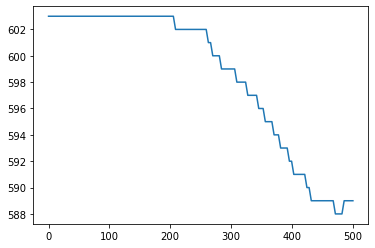

In [3]:
# prior_min= [0.0004, 0.0004, 0.09, 9e-7, 9e-7, 9e-7, 145, 148, 95, 50, 0.949, 4]
# prior_mmax = [0.0006, 0.0006, 2.5, 1.1e-6, 1.1e-6, 1.1e-6, 185, 105, 105, 80, 0.96, 7]

original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 150, 50, 100, 50, 0.96, 5]))
# test_theta = torch.from_numpy(np.array([0.0188, 0.05, 2.4, 2.6, 0.0000001, 0.0000001, 100, 50, 4]))
simulated_test = FACTS(original_theta)
x_time = np.linspace(0,500, num=140)
plt.plot(x_time, simulated_test)

In [4]:
# simulated_test.shape

### Run an example trial, or do a parameter sweep

#### 0 Auditory noise scale:

Low: 0.0001

High: 0.04


#### 1 Somatosensory noise scale:

Low: .002

High: 1


#### 2 TSE Process Scale:

Low: 0.0001

High: 5


#### 3 TSE Covariance Scale:

Low: 0.0000001

High: 5

#### 4 ASE Process Scale:

Low: 10e-12

High: 10e-6


#### 5 ASE Covariance Scale:

Low: 10e-12

High: 10e-4


#### 6 SensoryDelay Auditory Delay:

Low: 20

High: 105

#### x7 SensoryDelay Somato Delay:

Low: 45

High: 105

#### x8 TSE estimated_auditory_delay:

Low: 10 

High: 105

#### x9 ASE estimated_somat_delay

Low: 10 

High: 30

#### 10 cc_discount


### Load Parell's data to see what it looks like

In [5]:
# import observed data
data = scipy.io.loadmat('sbi_resources/parrell_2017/parrell_data.mat')

In [6]:
print(data['parrell_data'].dtype)
print(data['parrell_data']['means'][0,0][0,0][0].shape)
print(data['parrell_data']['stds'][0,0][0,0][0].shape)

[('means', 'O'), ('stds', 'O')]
(1, 171)
(1, 171)


### Print some of these data to see what it looks like

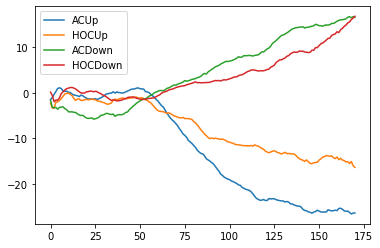

In [7]:
items = ['ACUp', 'HOCUp', 'ACDown', 'HOCDown']

for item in items:
    #pdb.set_trace()
    this_mean = data['parrell_data']['means'][0,0][item][0,0]
    if "Up" in item:
        this_mean = this_mean * -1
    plt.plot(this_mean.T, label=item)
    
plt.legend()

## See what the other data look like

In [8]:
# data_healthy_2019 = scipy.io.loadmat('sbi_resources/parrell_2019/fmtMatrix_shiftUpshiftDown_merged_OA.mat')
# print(data_healthy_2019.keys())

In [9]:
# print(data_healthy_2019['ffx']['rawf1'][0,0]['shiftUp'][0,0].shape)
# print(data_healthy_2019['ffx']['rawf1'][0,0]['shiftDown'][0,0].shape)
# print(data_healthy_2019['rfx']['rawf1'][0,0]['shiftUp'][0,0].shape)
# print(data_healthy_2019['rfx']['rawf1'][0,0]['shiftDown'][0,0].shape)
# print(data_healthy_2019['ffx']['rawf1'][0,0].dtype)

#### Plot healthy data

In [10]:
# healthy_ffx_shiftUp = data_healthy_2019['ffx']['rawf1'][0,0]['shiftUp'][0,0]
# healthy_ffx_shiftDown = data_healthy_2019['ffx']['rawf1'][0,0]['shiftDown'][0,0]

# # print(healthy_ffx_shiftUp)
# plt.plot(np.nanmean(healthy_ffx_shiftUp,1), label='shiftUp' )
# plt.plot(np.nanmean(healthy_ffx_shiftDown,1), label='shiftDown' )
# plt.legend()

#### Plot CD Data

In [11]:
# data_CD_2019 = scipy.io.loadmat('sbi_resources/parrell_2019/fmtMatrix_shiftUpshiftDown_merged_CD.mat')

# CD_ffx_shiftUp = data_CD_2019['ffx']['rawf1'][0,0]['shiftUp'][0,0]
# CD_ffx_shiftDown = data_CD_2019['ffx']['rawf1'][0,0]['shiftDown'][0,0]

# plt.plot(np.nanmean(CD_ffx_shiftUp,1), label='shiftUp' )
# plt.plot(np.nanmean(CD_ffx_shiftDown,1), label='shiftDown' )
# plt.legend()

In [12]:
# healthy_subj_means_shiftUp = data_healthy_2019['rfx']['rawf1'][0,0]['shiftUp'][0,0]
# plt.plot(healthy_subj_means_shiftUp, label='subjs_shiftUp')

In [13]:
# healthy_subj_means_shiftDown = data_healthy_2019['rfx']['rawf1'][0,0]['shiftDown'][0,0]
# plt.plot(healthy_subj_means_shiftDown, label='subjs_shiftDown')

In [14]:
# trial_cells_times = scipy.io.loadmat('sbi_resources/parrell_2017/magnitudes.mat')
# trial_cells_mat = scipy.io.loadmat('sbi_resources/formant_pert_data_cleaned.mat')['cleaned_matrix'].T # 1797 x 194 == trials by time

# trial_cells_times = scipy.io.loadmat('sbi_resources/formant_pert_time_cleaned.mat')['time_matrix'].T
# trial_cells_mat = scipy.io.loadmat('sbi_resources/formant_pert_data_cleaned.mat')['cleaned_matrix'].T 

# print(trial_cells_times.shape)
# print(trial_cells_mat.shape)
# trial_cells_times = trial_cells_times[:,0:150]
# trial_cells_mat = trial_cells_mat[:,0:150]
# print(trial_cells_times.shape)
# print(trial_cells_mat.shape)

# # # Alter the trial_cells so that they center to where FACTS centers
# trial_cells_mat = trial_cells_mat + 531

# # Plot and compare observed data to FACTS data
# plt.plot(trial_cells_times[0,:]*1000, trial_cells_mat[729,:])
# plt.axvline(x = 0, color = 'grey', ls=':')
# plt.title('A single real observation: Kyunghee dataset')
# # plt.ylim([510,535])

# plt.figure()
# plt.plot(trial_cells_times[0,:]*1000, np.mean(trial_cells_mat, 0))
# plt.axvline(x = 0, color = 'grey', ls=':')
# plt.title(f'Mean real observations N:{(trial_cells_mat.shape[0])}')
# # plt.ylim([510,535])

# # # # Now realign so that 
# # plt.figure()
# # plt.title('FACTS')
# # example_x = (np.arange(len(example))*5)-200
# # plt.plot(example_x,example)
# # plt.axvline(x = 0, color = 'grey', ls=':')
# # plt.xlabel('Time (ms)')
# # plt.ylabel('F1 HZ')
# # # plt.ylim([510,535])

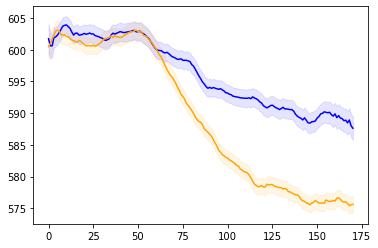

In [15]:
items = ['HOCUp', 'ACUp',]
offset = 603

# for item in items:
#     #pdb.set_trace()
#     this_mean = data['parrell_data']['means'][0,0][item][0,0]
#     if "Up" in item:
#         this_mean = this_mean * -1 + offset
#     plt.plot(this_mean.T, label=item)
    
# plt.legend()

healthy_mean = data['parrell_data']['means'][0,0]['HOCUp'][0,0][0,:] *-1 +offset +1
cereb_mean = data['parrell_data']['means'][0,0]['ACUp'][0,0][0,:] *-1 +offset -1

plt.plot(healthy_mean, color='blue', label='HC')
plt.plot(cereb_mean, color='orange', label='CD')

cereb_ci = np.abs( data['parrell_data']['stds'][0,0]['ACUp'][0,0][0,:] )
healthy_ci = np.abs(data['parrell_data']['stds'][0,0]['HOCUp'][0,0][0,:] )

plt.fill_between(range(len(cereb_mean)), (cereb_mean-cereb_ci), (cereb_mean+cereb_ci), color='orange', alpha=.1)
plt.fill_between(range(len(healthy_mean)), (healthy_mean-healthy_ci), (healthy_mean+healthy_ci), color='b', alpha=.1)


In [16]:
# print(data['parrell_data']['stds'][0,0]['ACUp'])

# print(data['parrell_data']['means'][0,0]['ACUp'][0,0][0,:])

# # print(cereb_ci)
# print(data['parrell_data']['means'][0,0]['ACUp'][0,0][0,:]  ==  data['parrell_data']['stds'][0,0]['ACUp'][0,0][0,:] )
# plt.plot(cereb_ci)

## Test if original theta leads to paper results

In [17]:
# x_time = np.linspace(-200,300, num=150)
# original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3]))
# formant_test = FACTS(original_theta)
# plt.plot(x_time, formant_test)

In [18]:
# print(np.min(trial_cells_mat[729,:]))
# print(np.min(np.mean(trial_cells_mat, 0)))
# print(np.min(example))

## Run Simulations and/or Load data

In [19]:

# import facts_for_SBI

load_instead = False

#Auditory noise scale:
# Low: 0.0001
# High: 0.04
#Somatosensory noise scale:
# Low: .002
# High: 1
#TSE Process Scale:
# Low: 0.0001
# High: 5
#TSE Covariance Scale:
# Low: 0.0000001
# High: 5
#ASE Process Scale:
# Low: 10e-12
# High: 10e-6
#ASE Covariance Scale:
# Low: 10e-12
# High: 10e-4
#SensoryDelay Auditory Delay:
# Low: 20
# High: 105
#SensoryDelay Somato Delay:
# Low: 45
# High: 105
#CC_reduction_from_delay
# Low: 20
# High: 60

# import your simulator, define your prior over the parameters
#prior_mean = 0.002

prior_min= [0.00001, 0.00002, 0.00001, 1e-8, 1e-8, 1e-8, 75, 75, 90, 30, 0.95, 1.0]
prior_mmax = [0.4, 1.0, 10.0, 1e-4, 1e-4, 1e-4, 163, 250, 250, 100, 0.96, 15]

# prior_min= [0.0001, 0.0001, 0.01, 1e-8, 1e-8, 1e-8, 140, 90, 90, 40, 0.95, 4.0]
# prior_mmax = [0.01, 0.001, 6.0, 1e-5, 1e-5, 1e-5, 200, 110, 110, 80, 0.96, 8.0]

# prior_min= [0.0001, 0.0001, 0.09, 1e-7, 1e-7, 1e-7, 145, 90, 90, 70, 0.95, 5]
# prior_mmax = [0.001, 0.001, 0.2, 1e-6, 1e-6, 1e-6, 155, 110, 110, 80, 0.96, 7]

# prior_min= [0.0004, 0.0004, 0.09, 9e-7, 9e-7, 9e-7, 145, 148, 95, 50, 0.949, 4]
# prior_mmax = [0.0006, 0.0006, 2.5, 1.1e-6, 1.1e-6, 1.1e-6, 185, 105, 105, 80, 0.96, 7]
    
# num_sim = 100
# num_workers = 6

# prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
# simulator2, prior = prepare_for_sbi(FACTS, prior)
# inference = SNPE(prior, density_estimator='nsf')
    
# # prior = torch.distributions.Uniform(torch.as_tensor(mmin), torch.as_tensor(mmax) )
# for jj in range(1):
#     print(jj)
#     if load_instead == True:    
#         try:
#             theta, x = simulate_for_sbi(simulator2, proposal=prior, num_simulations=num_sim, num_workers=num_workers)
#         #parameter_posterior = infer(simulator2, prior, method='SNPE', num_simulations=num_sim, num_workers=num_workers)
#     #         density_estimator = inference.append_simulations(theta, x).train()
#     #         posterior = inference.build_posterior(density_estimator)

#         # Save the theta and x
#             with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_theta_x_{num_sim}_local{jj}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#                 pickle.dump([theta, x], f)
#         # Save the posterior
# #         with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{num_sim}_local6.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
# #             pickle.dump([posterior], f)
#         except Exception as e:
#             print(e)
    
# # else:


## Load theta and x

In [20]:
# Get list of all pickle files matching string
all_files = os.listdir('./sbi_resources')
selected_files = [x for x in all_files if 'theta_x_' in x]
# selected_files = [x for x in all_files if 'theta_x_' in x and 'local' in x]


# Iterate through list
all_theta, all_x = torch.tensor(np.array([]), dtype=torch.float32), torch.tensor(np.array([]), dtype=torch.float32)
for file_string in selected_files:
    file = open(f'./sbi_resources/{file_string}', 'rb')
#     pdb.set_trace()
    this_theta, this_x = pickle.load(file)

    # Append 
    all_theta = torch.cat((all_theta, this_theta))
    all_x = torch.cat((all_x, this_x))

    # Close file
    file.close()    
print(all_theta.shape)
print(all_x.shape)




torch.Size([335400, 12])
torch.Size([335400, 140])


In [21]:
# Add data stored from multi-inference
# Aggregate the training data
all_files = os.listdir('./sbi-logs/multiSNPE')
selected_files_theta = [x for x in all_files if 'theta' in x ]
selected_files_x = [x for x in all_files if 'x' in x]


# Iterate through list
all_multi_theta, all_multi_x = torch.tensor(np.array([]), dtype=torch.float32), torch.tensor(np.array([]), dtype=torch.float32)
for i, file_string in enumerate(selected_files_x):
#     file = open(f'./sbi-logs/multiSNPE/{file_string}', 'rb')
    this_multi_theta = torch.load(f'./sbi-logs/multiSNPE/{selected_files_theta[i]}')
    this_multi_x = torch.load(f'./sbi-logs/multiSNPE/{selected_files_x[i]}')

    # Append 
    all_multi_theta = torch.cat((all_multi_theta, this_multi_theta))
    all_multi_x = torch.cat((all_multi_x, this_multi_x))
  


all_theta = torch.cat((all_theta, all_multi_theta))
all_x = torch.cat((all_x, all_multi_x))

print(all_theta.shape)
print(all_x.shape)

torch.Size([351900, 12])
torch.Size([351900, 140])


In [22]:
labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
          'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale',
          'Auditory Delay', 'Somato Delay', 'cc_discount_from_delay_TSE','cc_discount_from_delay_ASE', 
          'cc_decay', 'cc_minimum']

print(labels[-6])
filter_some_data=True
if filter_some_data == True:
    filter_bool = all_theta[:,-6] < 160
    all_x = all_x[filter_bool]
    all_theta = all_theta[filter_bool]
    
print('after too large Auditory Delay filter')
print(all_theta.shape)
print(all_x.shape)

Auditory Delay
after filter
torch.Size([248508, 12])
torch.Size([248508, 140])


In [23]:
if filter_some_data == True:
    filter_bool2 = (all_x != -1).all(axis=1)
    all_x = all_x[filter_bool2]
    all_theta = all_theta[filter_bool2]
  
print('after negative filter')
print(all_theta.shape)
print(all_x.shape)

after filter
torch.Size([228108, 12])
torch.Size([228108, 140])


#### Get density and posterior estimations

### Resample cereb data so that it resamples to 5ms to match FACTS

In [24]:
from scipy.interpolate import interp1d
###Downsample data to match simulator output 
def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

cereb_mean_ds = downsample(cereb_mean, 100)
healthy_mean_ds = downsample(healthy_mean, 100)

cereb_ci_ds = downsample(cereb_ci, 100)
healthy_ci_ds = downsample(healthy_ci, 100)

print(cereb_mean_ds.shape)

(100,)


### Create simulated data of preonset

The first 40 frames appear to have the same unperturbed data

(140,)


(-200.0, 500.0)

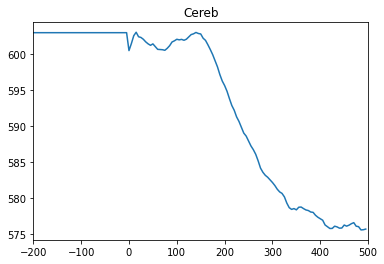

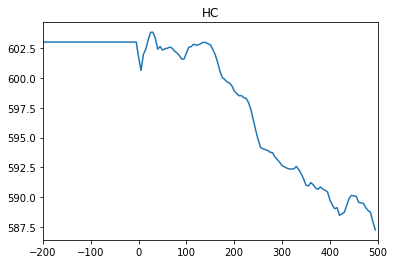

In [25]:
def create_precompensation_synthetic_data(orig_data):
#     precomp_mean = np.mean(orig_data[0:40])
#     precomp_std = np.std(orig_data[0:40])
    precomp_offset = 603

    cereb_synth = np.array([precomp_offset]*40)
    return np.concatenate( (cereb_synth, orig_data) )


cereb_mean_synth = create_precompensation_synthetic_data(cereb_mean_ds)
healthy_mean_synth = create_precompensation_synthetic_data(healthy_mean_ds)
#pdb.set_trace()
x_time = np.arange(-200,500,5)
plt.plot(x_time, cereb_mean_synth )
plt.title('Cereb')
#plt.ylim([500, 535])
plt.xlim([-200,500])

plt.figure()
plt.plot(x_time, healthy_mean_synth )
plt.title('HC')
#plt.ylim([500, 535])
print(healthy_mean_synth.shape)
plt.xlim([-200,500])



### Only grab the first 140 samples to match Ben's data

100 FACTS samples covers 0-500ms

40 FACTS samples covers 200ms preperturbation, which we wont plot

In [26]:
all_x_ds = all_x[:,0:140]
print(all_x_ds.shape)
print(all_theta.shape)
print(all_x_ds)
print(all_theta)

torch.Size([228108, 140])
torch.Size([228108, 12])
tensor([[603., 603., 603.,  ..., 581., 581., 581.],
        [603., 603., 603.,  ..., 587., 587., 587.],
        [603., 603., 603.,  ..., 585., 585., 585.],
        ...,
        [603., 603., 603.,  ..., 586., 585., 585.],
        [603., 603., 603.,  ..., 586., 586., 586.],
        [603., 603., 603.,  ..., 586., 586., 586.]])
tensor([[5.3645e-04, 5.2220e-04, 2.4911e+00,  ..., 6.8323e+01, 9.5263e-01,
         6.5235e+00],
        [4.8527e-04, 5.5286e-04, 1.0675e+00,  ..., 7.5629e+01, 9.4959e-01,
         6.1634e+00],
        [5.7562e-04, 4.0754e-04, 7.7728e-01,  ..., 6.7083e+01, 9.5224e-01,
         4.4549e+00],
        ...,
        [5.8274e-04, 5.6212e-04, 1.7776e+00,  ..., 6.8113e+01, 9.5928e-01,
         7.3807e+00],
        [5.8255e-04, 5.7805e-04, 1.6775e+00,  ..., 5.8861e+01, 9.5926e-01,
         7.4744e+00],
        [4.9676e-04, 4.8716e-04, 1.8152e+00,  ..., 6.8761e+01, 9.5929e-01,
         7.5238e+00]])


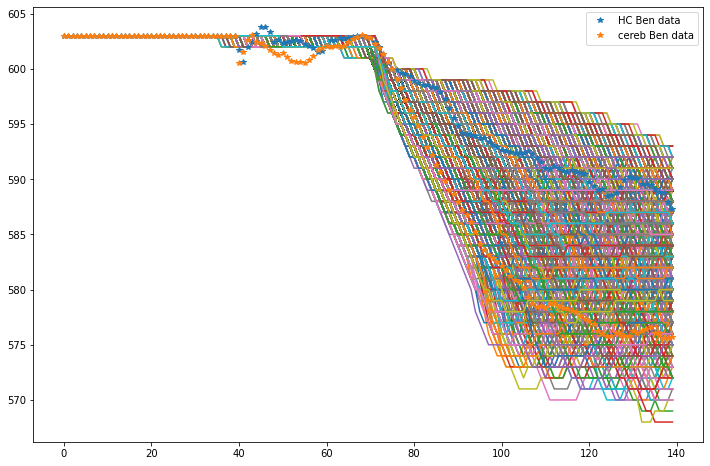

In [27]:
# Print some of the training data, just to make sure it is diverse
sample_size = all_x_ds.shape[0]
n = 10000
x_time = np.linspace(-200,700, num=140)
x_time_repeated = np.tile(x_time, n).reshape(n, -1)


random_samples_indices = np.random.choice(sample_size, n, replace=False)

plt.figure(figsize=(12, 8)) 
plt.plot(all_x_ds[random_samples_indices,:].T)
plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(cereb_mean_synth.reshape(1,140).T, '*', label='cereb Ben data' )

plt.legend()

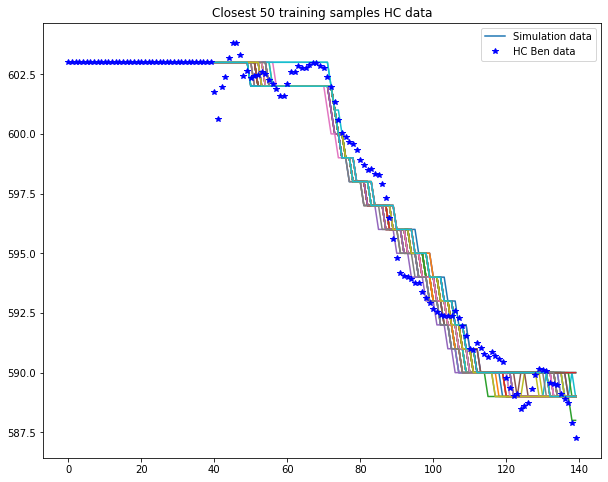

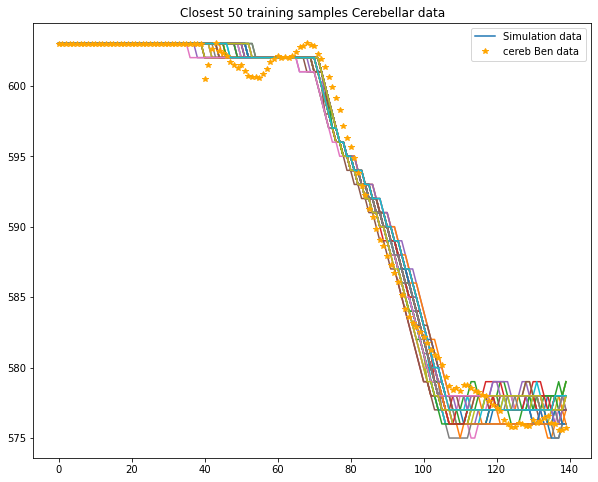

In [28]:
# Show the closest training samples
differencesHC = abs(all_x_ds - healthy_mean_synth)
differencesHC_summed = torch.sum(differencesHC, dim=1)
sorted_tensorHC, indicesHC = torch.sort(differencesHC_summed)

# Sort by sum
n = 50
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indicesHC[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(healthy_mean_synth.reshape(1,140).T, '*', color='Blue', label='HC Ben data' )
plt.title(f'Closest {n} training samples HC data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

# Plot which lines are closest
differences = abs(all_x_ds - cereb_mean_synth)
differences_summed = torch.sum(differences, dim=1)
sorted_tensor, indices = torch.sort(differences_summed)

# Sort by sum
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indices[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(cereb_mean_synth.reshape(1,140).T, '*', color='orange', label='cereb Ben data' )
plt.title(f'Closest {n} training samples Cerebellar data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

(140,)
(140,)


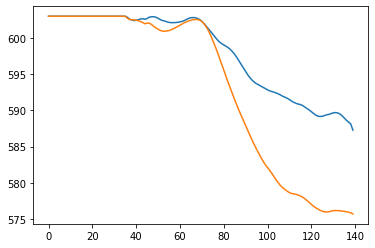

In [29]:
# What if we smooth the cereb_mean_synth and the healthy_mean_synth?

def smooth_np_convolve(data, window_size = 3):
    # Get a pad
    # Pad the data at the edges
    pad_width = window_size // 2
    padded_data = np.pad(data, pad_width, mode='edge')

    # Define the sliding average window size
    kernel = np.ones(window_size) / window_size

    # Apply the sliding average
    smoothed_data_interior = np.convolve(padded_data, kernel, mode='valid')

    smoothed_data = np.zeros_like(data)
    smoothed_data[0] = data[0]
    smoothed_data[-1] = data[-1]
    smoothed_data[1:-1] = smoothed_data_interior[1:-1]
    return smoothed_data

smoothed_cereb = smooth_np_convolve(cereb_mean_synth, 9)
smoothed_healthy = smooth_np_convolve(healthy_mean_synth, 9)
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
# plt.plot(cereb_mean_synth.reshape(1,140).T, '*', label='cereb Ben data' )

plt.plot(smoothed_healthy)
plt.plot(smoothed_cereb)
print(healthy_mean_synth.shape)
print(smoothed_healthy.shape)

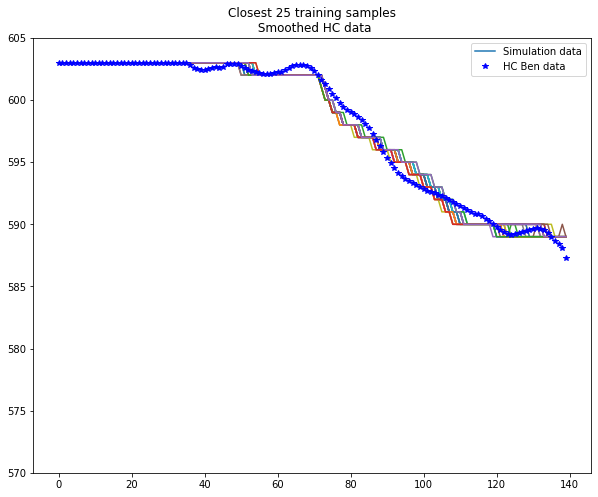

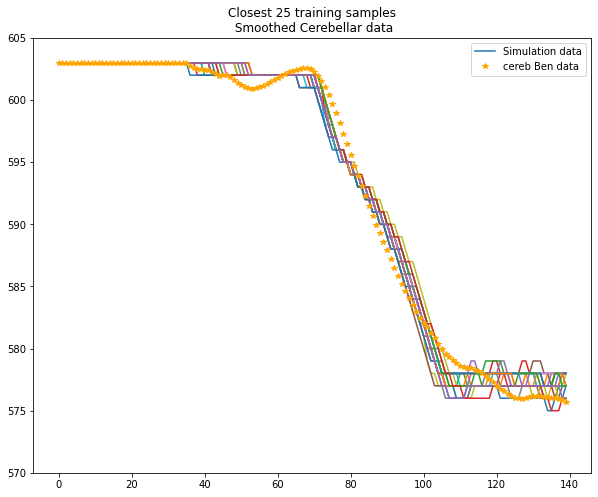

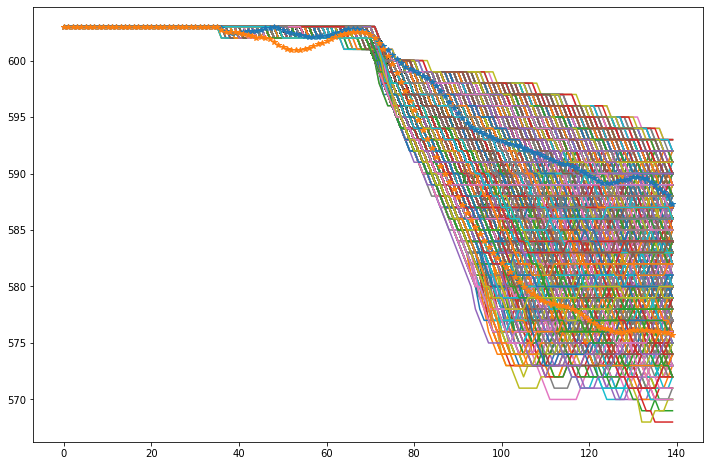

In [30]:
# Show the closest training samples
differencesHC = abs(all_x_ds - smoothed_healthy)
differencesHC_summed = torch.sum(differencesHC, dim=1)
sorted_tensorHC, indicesHC = torch.sort(differencesHC_summed)

# Sort by sum
n = 25
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indicesHC[0:n],:].T, label='Simulation data')
plt.plot(smoothed_healthy.reshape(1,140).T, '*', color='Blue', label='HC Ben data' )
plt.title(f'Closest {n} training samples\n Smoothed HC data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)

plt.ylim([570, 605])

# Plot which lines are closest
differences = abs(all_x_ds - smoothed_cereb)
differences_summed = torch.sum(differences, dim=1)
sorted_tensor, indices = torch.sort(differences_summed)

# Sort by sum
plt.figure(figsize=(10,8))
plt.plot(all_x_ds[indices[0:n],:].T, label='Simulation data')
# plt.plot(healthy_mean_synth.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(smoothed_cereb.reshape(1,140).T, '*', color='orange', label='cereb Ben data' )
plt.title(f'Closest {n} training samples\n Smoothed Cerebellar data')
lines_to_show = [0, -1]  # Index of lines to show in the legend
handles, labelss = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in lines_to_show]
selected_labels = [labelss[i] for i in lines_to_show]
plt.legend(selected_handles, selected_labels)
plt.ylim([570, 605])

plt.figure(figsize=(12, 8)) 
plt.plot(all_x_ds[random_samples_indices,:].T)
plt.plot(smoothed_healthy.reshape(1,140).T, '*', label= 'HC Ben data')
plt.plot(smoothed_cereb.reshape(1,140).T, '*', label='cereb Ben data' )

In [31]:
prior = utils.torchutils.BoxUniform(torch.as_tensor(prior_min), torch.as_tensor(prior_mmax) )
simulator2, prior = prepare_for_sbi(FACTS, prior)
inference = SNPE(prior, density_estimator='nsf')

run_and_save = True
print(len(prior_min))
# Downsample all_x
if run_and_save:
    density_estimator = inference.append_simulations(all_theta, all_x_ds).train(force_first_round_loss=True,
                                                                                discard_prior_samples=True, 
                                                                                show_train_summary=True,
                                                                               training_batch_size=32,
                                                                                learning_rate = 5e-5,
                                                                               ) # Look more into force_first_round_loss=True
#     density_estimator = inference.append_simulations(all_theta[0:100000,:], all_x_ds[0:100000]).train(force_first_round_loss=True)
    posterior = inference.build_posterior(density_estimator)

    # Save the posterior
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_local_nsf.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([posterior], f)
        
else:
#     with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_72000_local.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_767179_okay.pkl', 'rb') as f:  # Python 3: open(..., 'wb')

#         pdb.set_trace()
        object_file = pickle.load(f)
        posterior = object_file[0]

12
 Neural network successfully converged after 80 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 80
        Best validation performance: 61.4150
        -------------------------
        


In [32]:
# # Save the posterior
print(all_theta.size()[0])
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([posterior], f)
    
# # Save the inference
with open(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([inference], f)


228108


/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/sbi/inference/base.py:428: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  "When the inference object is pickled, the behaviour of the loaded object "


## Sample the posterior for the mean of all trials

In [33]:
sample_size = 250
# sample_size = all_theta.size()[0]

In [34]:
# samples_test_FACTS = posterior.sample((sample_size,), x=simulated_test)
# samples_test_FACTS = posterior.sample((702438,), x=simulated_test)

In [35]:
# samples_cereb = posterior.sample((all_theta.size()[0],), x=cereb_mean_synth)
samples_cereb = posterior.sample((sample_size,), x=cereb_mean_synth)
# samples_cereb = posterior.sample((sample_size,), x=smoothed_cereb)

Drawing 250 posterior samples:   0%|          | 0/250 [00:00<?, ?it/s]

/Users/alvincepongos/opt/anaconda3/envs/FACTS_SBI_py37/lib/python3.7/site-packages/nflows/transforms/lu.py:81: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2121.)
  outputs.t(), lower, upper=False, unitriangular=True


In [36]:
# samples_healthy = posterior.sample((all_theta.size()[0],), x=healthy_mean_synth)
samples_healthy = posterior.sample((sample_size,), x=healthy_mean_synth)
# samples_healthy = posterior.sample((sample_size,), x=smoothed_healthy)

Drawing 250 posterior samples:   0%|          | 0/250 [00:00<?, ?it/s]

In [37]:
labels = ['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale',
          'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale',
          'Auditory Delay', 'Somato Delay', 'cc_discount_from_delay_TSE','cc_discount_from_delay_ASE', 
          'cc_decay', 'cc_minimum']

In [38]:
# plt.rcParams.update({'font.size': 16})
# plt.xticks(rotation=70)
# out = pairplot(samples, figsize=(26,15), upper='kde', diag='kde', labels=labels, set_xticks['rotation']=45)

In [39]:
# print(out[1][0][0])
# got_ticks = out[1][0][0].get_xticks()
# out[1][0][0].set_xticks(got_ticks, rotation=45)

In [40]:
# samples_cereb[1::10].size()

In [41]:
# from itertools import cycle

# data = sns.load_dataset('iris')
# display(data)

# g = sns.PairGrid(data, hue='species')
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# # pg.map_upper(plt.scatter)

In [42]:
# display(px)
# print(samples_test_FACTS.shape)

In [43]:
# plt.rcParams.update({'font.size': 12})

# #Append test_FACTS
# px_testFACTS = pd.DataFrame(samples_test_FACTS).astype("float")
# display(px_testFACTS)
# px_testFACTS.set_axis(labels, axis="columns", inplace=True)
# px_testFACTS["Group"] = "TestFACTS"

# px2 = px_testFACTS
# g = sns.PairGrid(px2, diag_sharey=False, corner=True)

# # g = sns.pairplot(px, corner=True, kind='hist')
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# g.add_legend()

In [44]:

# display(HTML("<style>.container { width:100% !important; }</style>"))

# px_healthy = pd.DataFrame(samples_healthy[1::100]).astype("float")
# px_healthy.set_axis(labels, axis="columns", inplace=True)
# px_healthy["Group"] = "HC"

# g = sns.PairGrid(px_healthy, diag_sharey=False, corner=True, hue="Group", hue_order=['HC'])
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)
# g.add_legend()

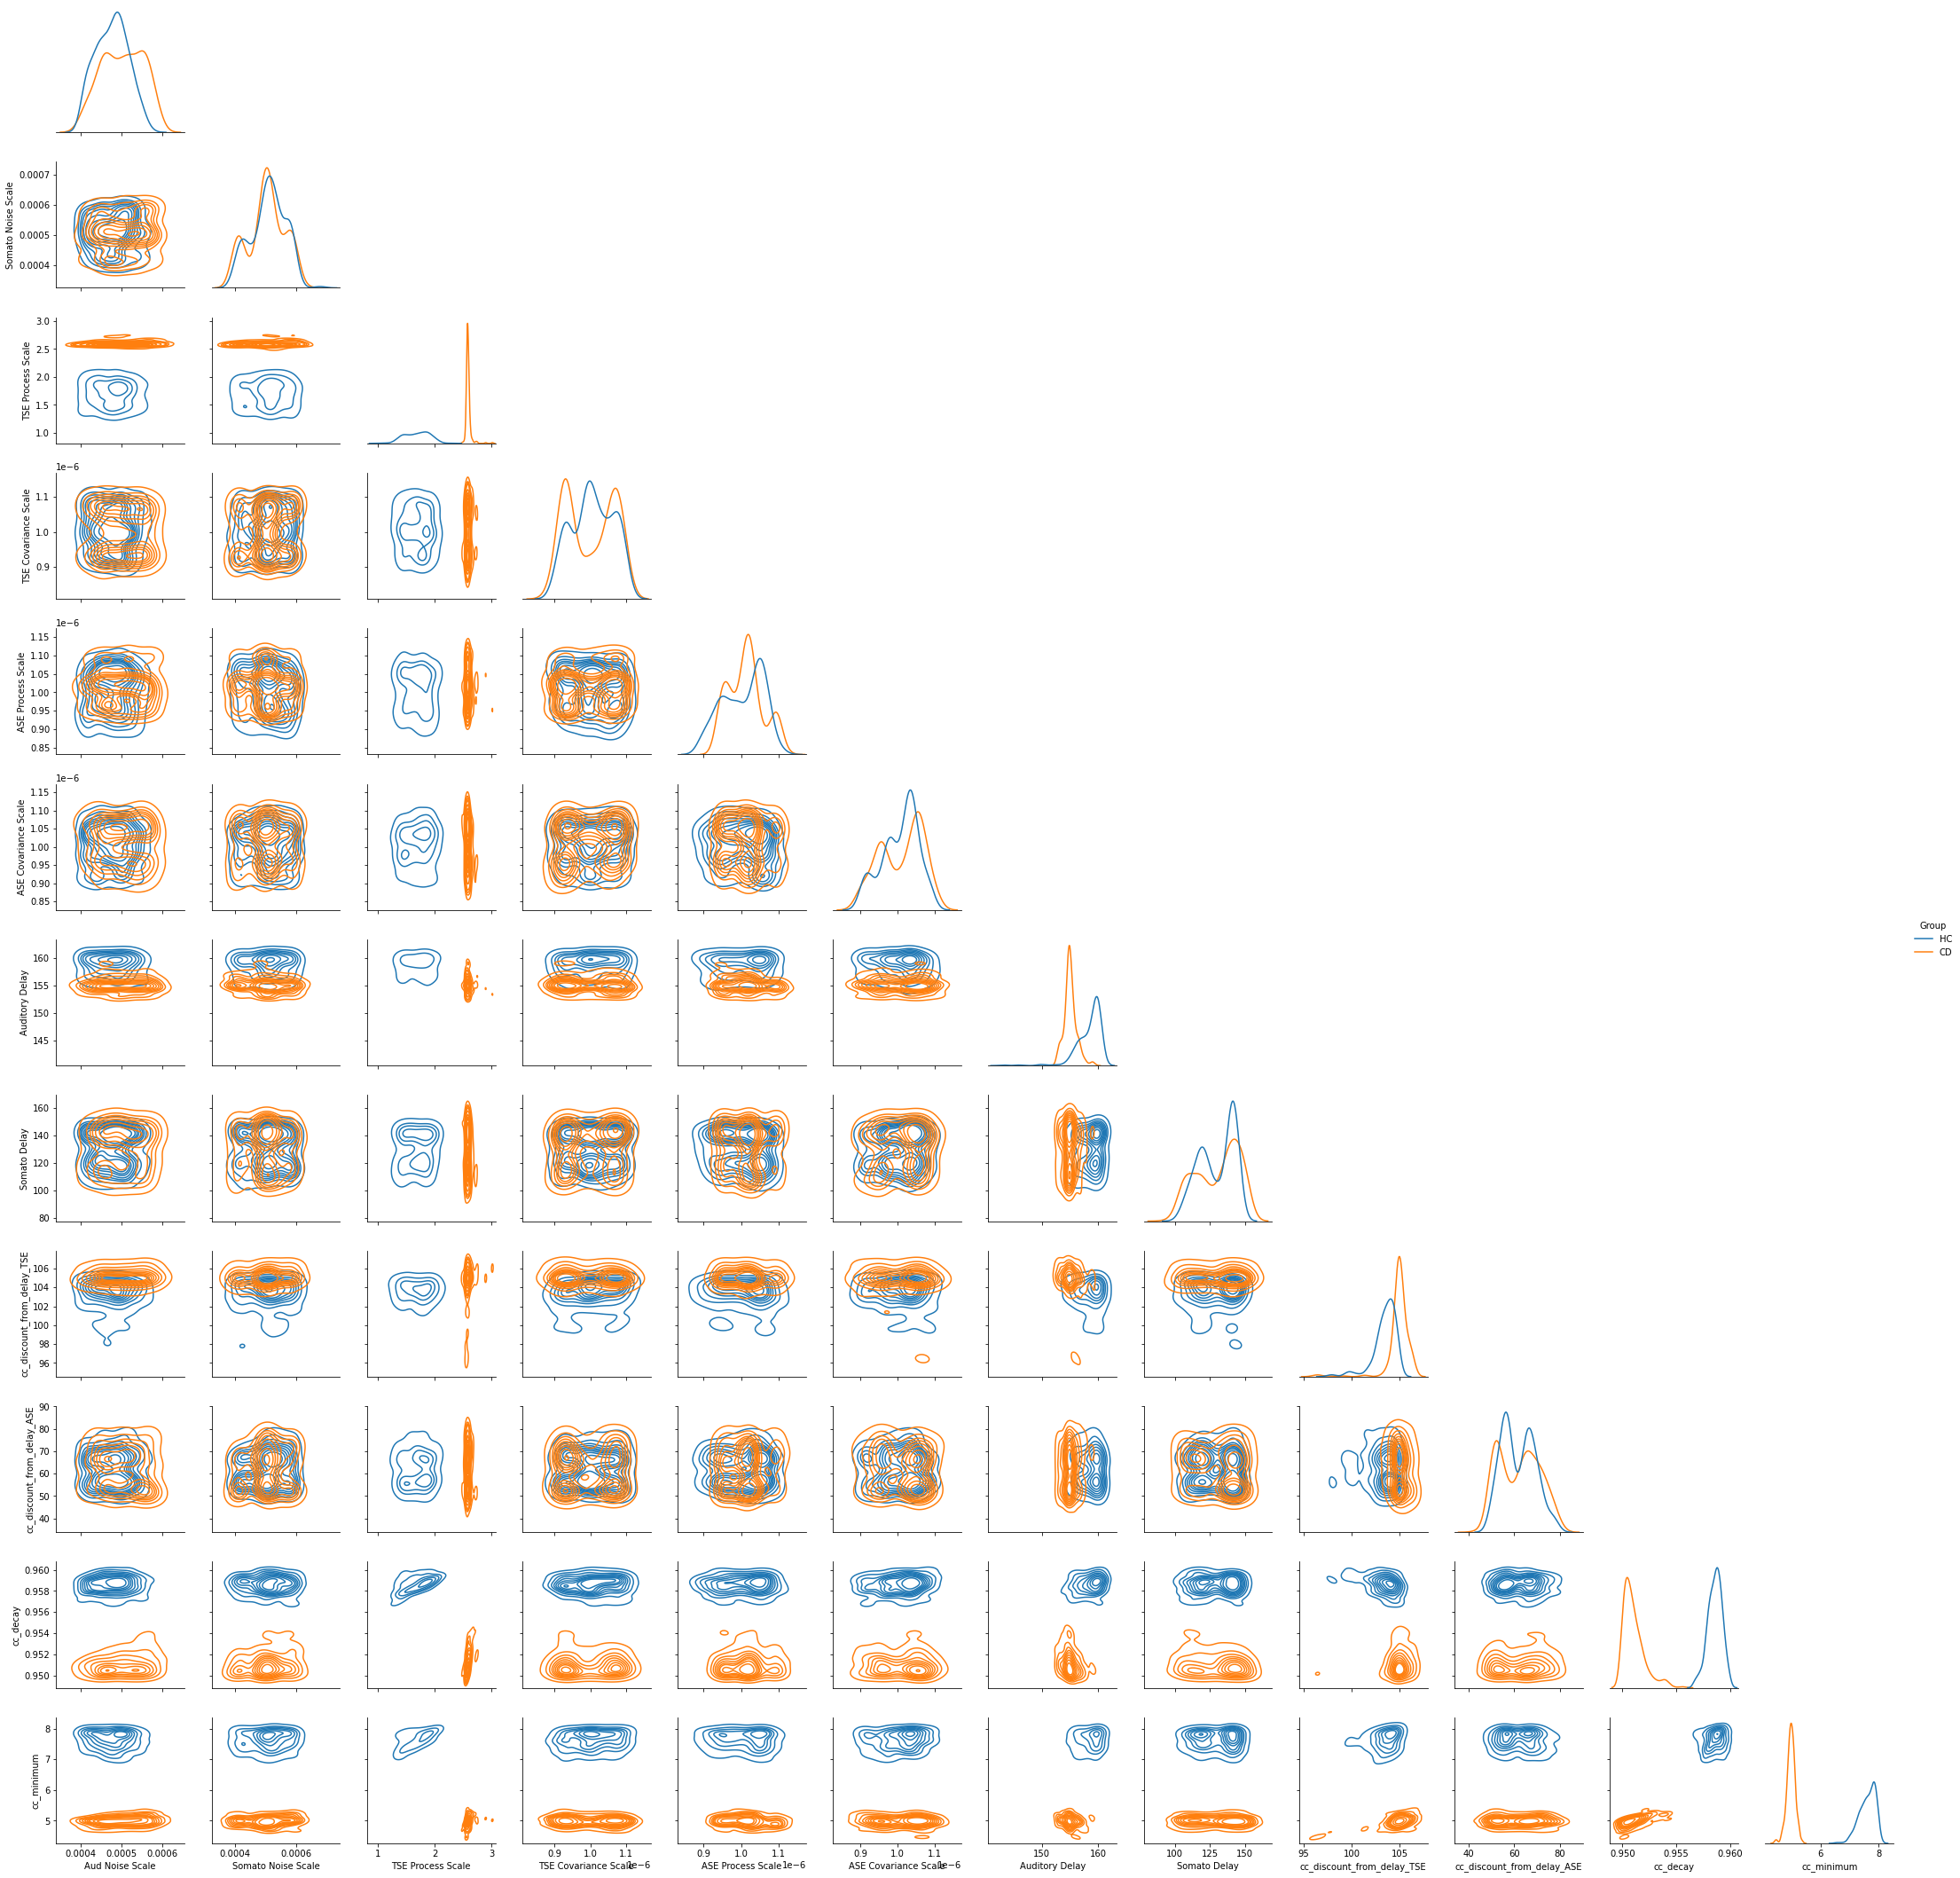

In [45]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Append Healthy data
px_healthy = pd.DataFrame(samples_healthy).astype("float")
px_healthy.set_axis(labels, axis="columns", inplace=True)
px_healthy["Group"] = "HC"

# Append CD
px = pd.DataFrame(samples_cereb).astype("float")
px.set_axis(labels, axis="columns", inplace=True)
px["Group"] = "CD"

#Append test_FACTS
# px_testFACTS = pd.DataFrame(samples_test_FACTS[1::2]).astype("float")
# px_testFACTS.set_axis(labels, axis="columns", inplace=True)
# px_testFACTS["Group"] = "TestFACTS"

# px2 = px_testFACTS
px2 = pd.concat([px,px_healthy], ignore_index=True)

g = sns.PairGrid(px2, diag_sharey=False, corner=True, hue="Group", hue_order=['HC','CD'])

# g = sns.pairplot(px, corner=True, kind='hist')
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()

In [46]:
# import pandas as pd
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# px = pd.DataFrame(samples_healthy[1::10]).astype("float")
# px.set_axis(labels, axis="columns", inplace=True)
# g = sns.PairGrid(px, diag_sharey=False, corner=True)
# # g = sns.pairplot(px, corner=True, kind='hist')
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot)

### Test which parameters might need to be changed to get close to the observed data

In [47]:
# torch.set_printoptions(sci_mode=False)

# original_theta = torch.from_numpy(np.array([0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3]))
# test_theta = torch.from_numpy(np.array([0.005, 0.005, .1, 2.0, 0.0000001, 0.0000001, 150, 50, 5]))
# print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# # pdb.set_trace()

# test_set = [50,100,120]

# for ii in range(5):
#     #pdb.set_trace()
# #     test_theta = original_theta.detach().clone()
# #     test_theta2[-1] = original_theta[-1]*2
#     manual_test = FACTS(test_theta)    
#     x_time = np.linspace(0,500, num=100)

#     plt.figure(figsize=(14,10))
#     plt.plot(x_time, healthy_mean_synth[40:140], 'k',label='Mean of observed trials')
#     plt.plot(x_time, simulated_test[40:140], 'b',label=f'Original theta')
#     plt.plot(x_time, manual_test[40:140], 'red',label=f'Manual theta test')
# #     plt.axvline(x = 0, color = 'grey', ls=':')
#     plt.legend()

#     plt.xlabel('Time (ms)')
#     plt.ylabel('Formant response (Hz)')
#     plt.title('Healthy Empirical')

### Plot estimated formant to observed formant

In [48]:
# Helper function
def get_modes(data):
    # Initialize list to store modes
    modes = []
    
    # Iterate over each dimension (column) in the data
    for i in range(data.shape[1]):
        kde = stats.gaussian_kde(data[:, i])
        x = np.linspace(data[:, i].min(), data[:, i].max(), 1000)
        mode_x = x[np.argmax(kde.evaluate(x))]
        modes.append(mode_x)
    
    return np.array(modes)

In [49]:
# from scipy import stats

# plt.rcParams.update({'font.size': 22})

# torch.set_printoptions(sci_mode=True)

# posterior_modes_FACTS = stats.mode(samples_test_FACTS,0)
# posterior_modes_FACTS = torch.from_numpy(posterior_modes_FACTS[0][0])
# print(f'poster modes {posterior_modes_FACTS}')
# # print(f'original theta {original_theta}')
# # pdb.set_trace()

# all_simulated_formant_facts = np.array([])
# for ii in range(5):
#     all_simulated_formant_facts = FACTS(posterior_modes_FACTS)
#     if ii == 0:
#         all_simulated_formant = all_simulated_formant_facts
#     else:
#         all_simulated_formant = np.vstack((all_simulated_formant, all_simulated_formant_facts))
        
# #pdb.set_trace()
# # simulated_formant = FACTS(posterior_modes_FACTS)
# mean_formants = np.mean(all_simulated_formant, axis=0)
# ci = np.std(all_simulated_formant, axis=0)

# x_time = np.linspace(-200,700, num=140)

# plt.figure(figsize=(14,10))
# # Plot "Estimations"
# plt.plot(x_time, mean_formants, label='estimated from posteriors')
# plt.fill_between(x_time, (mean_formants-ci), (mean_formants+ci), color='b', alpha=.1)

# # Plot Empirical Data
# plt.plot(x_time, simulated_test, 'k',label='FACTS output')
# # plt.fill_between(x_time, (simulated_test-healthy_ci), (simulated_test+healthy_ci), color='k', alpha=.1)

# #  plt.axvline(x = 0, color = 'grey', ls=':')
# plt.legend()

# plt.xlabel('Time (ms)')
# plt.ylabel('Formant response (Hz)')
# plt.title('FACTS Empirical')

['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale', 'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale', 'Auditory Delay', 'Somato Delay', 'cc_discount_from_delay_TSE', 'cc_discount_from_delay_ASE', 'cc_decay', 'cc_minimum']
poster modes tensor([4.780595190823078155517578125000e-04,
        5.109928315505385398864746093750e-04,
        1.709426641464233398437500000000e+00,
        1.001929263111378531903028488159e-06,
        1.013652763504069298505783081055e-06,
        1.023571485347929410636425018311e-06,
        1.592820434570312500000000000000e+02,
        1.316572570800781250000000000000e+02,
        1.037109832763671875000000000000e+02,
        6.152279281616210937500000000000e+01,
        9.586654901504516601562500000000e-01,
        7.655457019805908203125000000000e+00])
posterior_modes_HC_manual_test tensor([5.000000237487256526947021484375e-04,
        5.000000237487256526947021484375e-04,
        1.000000014901161193847656250000e-01,
        9.999

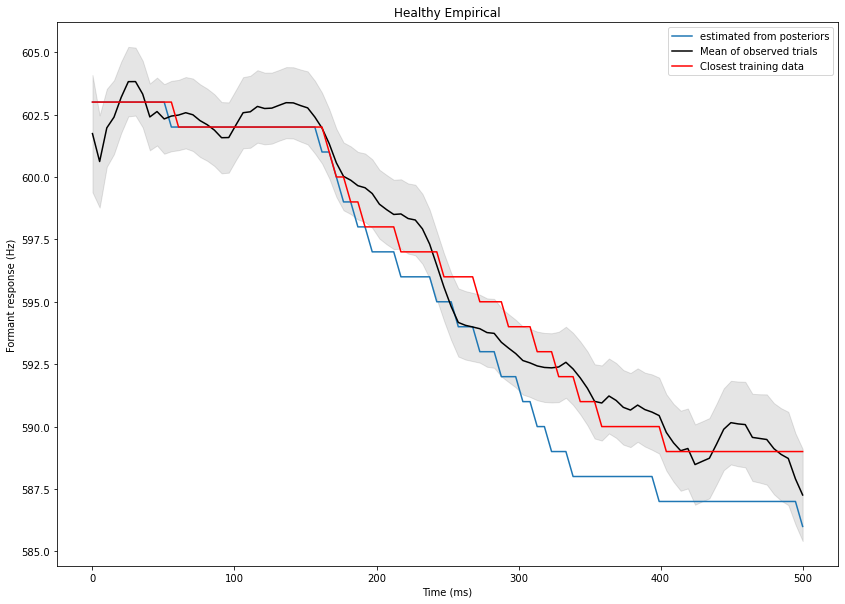

In [50]:
torch.set_printoptions(sci_mode=False)
torch.set_printoptions(precision=30)

print(labels)
# posterior_modes_HC = stats.mode(samples_healthy,0)
# posterior_modes_HC = torch.from_numpy(posterior_modes_HC[0][0])

# posterior_modes_HC = get_modes(samples_healthy)
# posterior_modes_HC = np.average(samples_healthy, axis=0)
posterior_modes_HC = np.median(samples_healthy, axis=0)
posterior_modes_HC = torch.from_numpy(posterior_modes_HC)
print(f'poster modes {posterior_modes_HC}')
# print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# pdb.set_trace()


# posterior_modes_HC_manual_test = posterior_modes_HC.detach().clone()
# posterior_modes_HC_manual_test[-2] = 0.98
# posterior_modes_HC_manual_test[2] = 0.04
# posterior_modes_HC_manual_test[5] = posterior_modes_HC[5] * 100

posterior_modes_HC_manual_test = torch.tensor([0.0005,
            0.0005,
            0.1,
            0.000001, 
            0.000001, 
            0.000001,
            150.0,
            100.0,
            100.0,
            75.0,
            0.958,
            6.0]) 

# posterior_modes_HC2 = posterior_modes_HC.clone()
# posterior_modes_HC2[2] = posterior_modes_HC_manual_test[2]


for ii in range(1):
    simulated_formant_H = FACTS(posterior_modes_HC)
    print(f'posterior_modes_HC_manual_test {posterior_modes_HC_manual_test}')
#     simulated_formant_manual_test = FACTS(posterior_modes_HC_manual_test)
#     pdb.set_trace() 
    # Plot data
    x_time = np.linspace(0,500, num=100)
    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_H[40:140], label='estimated from posteriors')

    plt.plot(x_time, healthy_mean_synth[40:140], 'k',label='Mean of observed trials')
    plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='k', alpha=.1)
    plt.plot(x_time, all_x_ds[indicesHC[0:1],40:].T, color='red', label='Closest training data')

#     plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual tuning')
    #     plt.axvline(x = 0, color = 'grey', ls=':')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('Healthy Empirical')

# print(f'difference of parameter values = {posterior_modes_HC - posterior_modes_HC_manual_test}')


In [51]:
np.set_printoptions(precision=4)
pd.set_option('display.float_format', '{:.7f}'.format)
np.set_printoptions(suppress=True)

best_HC_theta = all_theta[indicesHC[0],:]
print(best_HC_theta)
this_df_HC = pd.DataFrame({'Parameter label': labels,
#                         'posterior_modes_CD_manual_test': posterior_modes_HC_manual_test.numpy().tolist(),
                        'best_training_data':best_HC_theta.numpy().tolist(),
                       'posterior_modes_C': posterior_modes_HC.numpy().tolist(),
                       'difference in parameter tensors': (posterior_modes_HC - best_HC_theta).numpy().tolist(),
                       'Percent diff': ((posterior_modes_HC - best_HC_theta)/best_HC_theta*100).numpy().tolist()
                       })

display(this_df_HC)


tensor([4.278334381524473428726196289062e-04,
        4.265118041075766086578369140625e-04,
        9.020525217056274414062500000000e-01,
        9.099654789679334498941898345947e-07,
        9.794684956432320177555084228516e-07,
        9.926910706781200133264064788818e-07,
        1.581354064941406250000000000000e+02,
        9.905419921875000000000000000000e+01,
        9.873561096191406250000000000000e+01,
        7.559064483642578125000000000000e+01,
        9.627561569213867187500000000000e-01,
        7.639458656311035156250000000000e+00])


Parameter label  best_training_data  posterior_modes_C  \
0              Aud Noise Scale           0.0004278          0.0004781   
1           Somato Noise Scale           0.0004265          0.0005110   
2            TSE Process Scale           0.9020525          1.7094266   
3         TSE Covariance Scale           0.0000009          0.0000010   
4            ASE Process Scale           0.0000010          0.0000010   
5         ASE Covariance Scale           0.0000010          0.0000010   
6               Auditory Delay         158.1354065        159.2820435   
7                 Somato Delay          99.0541992        131.6572571   
8   cc_discount_from_delay_TSE          98.7356110        103.7109833   
9   cc_discount_from_delay_ASE          75.5906448         61.5227928   
10                    cc_decay           0.9627562          0.9586655   
11                  cc_minimum           7.6394587          7.6554570   

    difference in parameter tensors  Percent diff  
0                         0.0000502    11.7396336  
1                         0.0000845    19.8074303  
2                         0.8073741    89.5041199  
3                         0.0000001    10.1062937  
4                         0.0000000     3.4900832  
5                         0.0000000     3.1107779  
6                         1.1466370     0.7250982  
7                        32.6030579    32.9143600  
8                         4.9753723     5.0390859  
9                       -14.0678520   -18.6105728  
10                       -0.0040907    -0.4248912  
11                        0.0159984     0.2094175

['Aud Noise Scale', 'Somato Noise Scale', 'TSE Process Scale', 'TSE Covariance Scale', 'ASE Process Scale', 'ASE Covariance Scale', 'Auditory Delay', 'Somato Delay', 'cc_discount_from_delay_TSE', 'cc_discount_from_delay_ASE', 'cc_decay', 'cc_minimum']
poster modes tensor([5.036192014813423156738281250000e-04,
        5.069267936050891876220703125000e-04,
        2.580135345458984375000000000000e+00,
        1.001055352389812469482421875000e-06,
        1.014650024444563314318656921387e-06,
        1.026051563712826464325189590454e-06,
        1.548923034667968750000000000000e+02,
        1.355278320312500000000000000000e+02,
        1.049807891845703125000000000000e+02,
        6.344041824340820312500000000000e+01,
        9.508087635040283203125000000000e-01,
        4.980821609497070312500000000000e+00])
% difference in parameter tensors tensor([[ 0.009613374248147010803222656250, -0.079686678946018218994140625000,
          0.207990199327468872070312500000, -0.0551439709961414337158

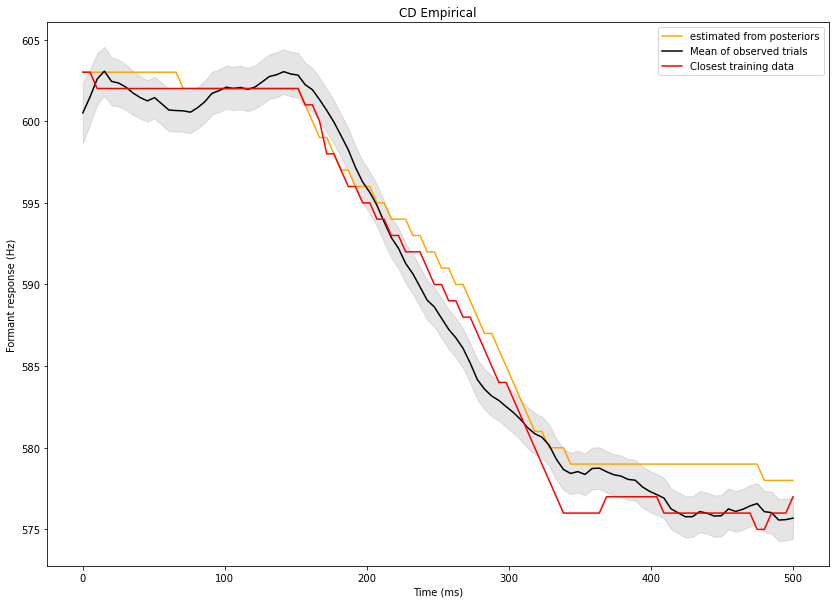

In [52]:
print(labels)
# posterior_modes_C = stats.mode(samples_cereb,0)
# posterior_modes_C = torch.from_numpy(posterior_modes_C[0][0])

# posterior_modes_C = get_modes(samples_cereb)
posterior_modes_C = np.median(samples_cereb, axis=0)
# posterior_modes_C = np.average(samples_cereb, axis=0)
posterior_modes_C = torch.from_numpy(posterior_modes_C)
print(f'poster modes {posterior_modes_C}')
# print(posterior_modes.shape)
# pdb.set_trace()

#posterior_modes_C_manual_test = posterior_modes_C.detach().clone()
posterior_modes_CD_manual_test = torch.tensor([0.005,
            0.0005,
            4.0,
            0.0000001, 
            0.0001, 
            0.000001,
            150.0,
            100.0,
            100.8,
            55.0,
            0.955,
            6.0])


# print(f'posterior_modes_C_manual_test {posterior_modes_C_manual_test}')
posterior_modes_C2 = posterior_modes_C.clone()
posterior_modes_C2[3] = posterior_modes_CD_manual_test[3]

best_theta = all_theta[indices[0:1],:]
# Sort by sum
for ii in range(1):
    #pdb.set_trace()
    simulated_formant_C = FACTS(posterior_modes_C)
#     simulated_formant_manual_test = FACTS(posterior_modes_CD_manual_test)
    
    x_time = np.linspace(0,500, num=100)

    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_C[40:140], 'orange', label='estimated from posteriors')
    plt.plot(x_time, cereb_mean_synth[40:140], 'k',label='Mean of observed trials')
#     plt.plot(x_time, all_simulated_formant_facts
    plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='k', alpha=.1)
    #plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual tuning')
#     plt.plot(x_time, simulated_formant_manual_test2[40:140], 'magenta',label='Manual test')
    plt.plot(x_time, all_x_ds[indices[0:1],40:].T, label='Closest training data', color='red')
#     plt.axvline(x = 0, color = 'grey', ls=':')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('CD Empirical')
    
# print(f'% difference in parameter tensors {(posterior_modes_C - posterior_modes_CD_manual_test)/posterior_modes_CD_manual_test}')
print(f'% difference in parameter tensors {(posterior_modes_C - best_theta)/best_theta}')



In [53]:
np.set_printoptions(precision=4)
pd.set_option('display.float_format', '{:.7f}'.format)

# posterior_modes_C - best_theta)/best_theta
print(best_theta[0].tolist())
print((posterior_modes_C - best_theta[0]).numpy().tolist())
this_df = pd.DataFrame({'Parameter label': labels,
                        'best training data': best_theta[0].tolist(),
                       'posterior_modes_C': posterior_modes_C.numpy().tolist(),
                       'difference in parameter tensors': (posterior_modes_C - best_theta[0]).numpy().tolist(),
                       'Percent diff': ((posterior_modes_C - best_theta[0])/best_theta[0]*100).numpy().tolist()
                       })

display(this_df)

[0.0004988238215446472, 0.000550819793716073, 2.1358909606933594, 1.0594792456686264e-06, 1.0040366760222241e-06, 1.0771718734758906e-06, 155.05714416503906, 130.93141174316406, 100.04774475097656, 74.16704559326172, 0.9500999450683594, 4.003188610076904]
[4.795379936695099e-06, -4.389300011098385e-05, 0.444244384765625, -5.842389327881392e-08, 1.0613348422339186e-08, -5.112030976306414e-08, -0.1648406982421875, 4.5964202880859375, 4.93304443359375, -10.726627349853516, 0.0007088184356689453, 0.977632999420166]


Parameter label  best training data  posterior_modes_C  \
0              Aud Noise Scale           0.0004988          0.0005036   
1           Somato Noise Scale           0.0005508          0.0005069   
2            TSE Process Scale           2.1358910          2.5801353   
3         TSE Covariance Scale           0.0000011          0.0000010   
4            ASE Process Scale           0.0000010          0.0000010   
5         ASE Covariance Scale           0.0000011          0.0000010   
6               Auditory Delay         155.0571442        154.8923035   
7                 Somato Delay         130.9314117        135.5278320   
8   cc_discount_from_delay_TSE         100.0477448        104.9807892   
9   cc_discount_from_delay_ASE          74.1670456         63.4404182   
10                    cc_decay           0.9500999          0.9508088   
11                  cc_minimum           4.0031886          4.9808216   

    difference in parameter tensors  Percent diff  
0                         0.0000048     0.9613374  
1                        -0.0000439    -7.9686680  
2                         0.4442444    20.7990208  
3                        -0.0000001    -5.5143971  
4                         0.0000000     1.0570678  
5                        -0.0000001    -4.7457895  
6                        -0.1648407    -0.1063096  
7                         4.5964203     3.5105560  
8                         4.9330444     4.9306903  
9                       -10.7266273   -14.4627943  
10                        0.0007088     0.0746046  
11                        0.9776330    24.4213581

Text(0.5, 1.0, 'Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

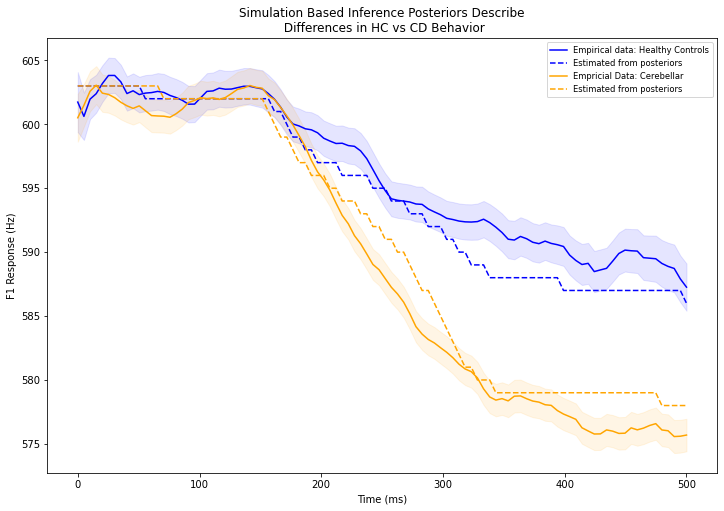

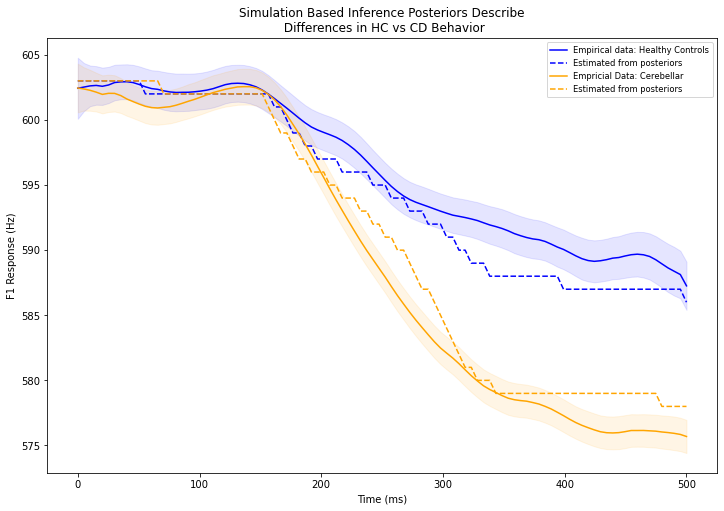

In [54]:
x_time = np.linspace(0,500, num=100)

plt.figure(figsize=(12,8))
plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Empirical data: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Empricial Data: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='small')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

# Plot smoothed
# smoothed_cereb = smooth_np_convolve(cereb_mean_synth, 9)
# smoothed_healthy = smooth_np_convolve(healthy_mean_synth, 9)
plt.figure(figsize=(12,8))
plt.plot(x_time, smoothed_healthy[40:140], 'blue',label='Empirical data: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (smoothed_healthy[40:140]-healthy_ci_ds), (smoothed_healthy[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, smoothed_cereb[40:140], 'orange',label='Empricial Data: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (smoothed_cereb[40:140]-cereb_ci_ds), (smoothed_cereb[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='small')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

poster modes tensor([3.992841520812362432479858398438e-04,
        3.934657434001564979553222656250e-04,
        2.485422134399414062500000000000e+00,
        8.889735454431502148509025573730e-07,
        1.010005348689446691423654556274e-06,
        8.954453392107097897678613662720e-07,
        1.526715393066406250000000000000e+02,
        9.602635955810546875000000000000e+01,
        9.608055114746093750000000000000e+01,
        4.429564285278320312500000000000e+01,
        9.500011205673217773437500000000e-01,
        4.428082466125488281250000000000e+00])
Warning |ASE value| greater than 3, results are beyond training data regime
Warning |ASE value| greater than 3, results are beyond training data regime
Warning |ASE value| greater than 3, results are beyond training data regime


Text(0.5, 1.0, 'CD Empirical')

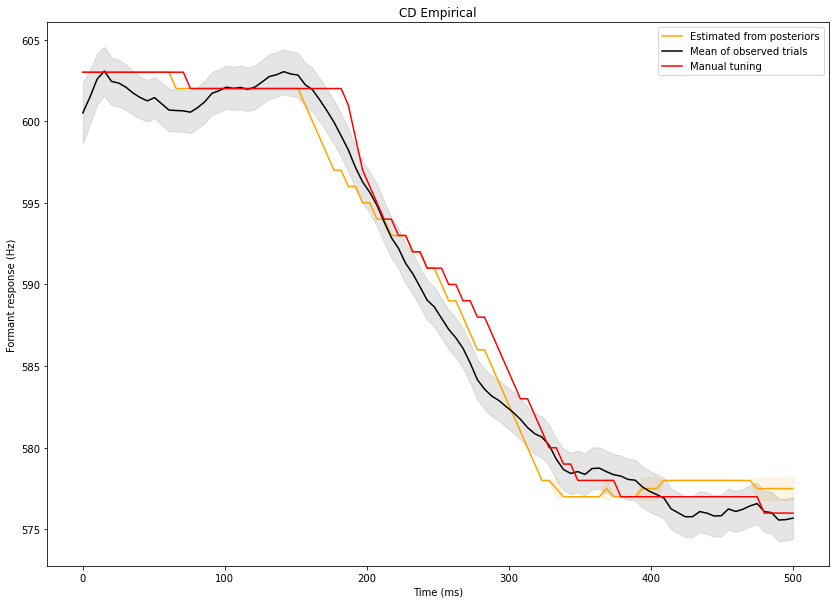

In [55]:
posterior_modes_C = stats.mode(samples_cereb,0)
posterior_modes_C = torch.from_numpy(posterior_modes_C[0][0])
print(f'poster modes {posterior_modes_C}')
# pdb.set_trace()

# posterior_modes_HC_manual_test = posterior_modes_HC.detach().clone()
# posterior_modes_HC_manual_test[-1] = 8
# posterior_modes_HC_manual_test[5] = posterior_modes_HC[5] * 100

posterior_modes_CD_manual_test = torch.tensor([0.005,
            0.0005,
            4.0,
            0.0000001, 
            0.0001, 
            0.000001,
            180.0,
            100.0,
            100.8,
            55.0,
            0.955,
            6.0])


all_simulated_formant_CD = np.array([])
for ii in range(2):
    simulated_formant = FACTS(posterior_modes_C)
    simulated_formant_manual_test = FACTS(posterior_modes_CD_manual_test)
#     pdb.set_trace()
    if ii == 0:
        all_simulated_formant_CD = simulated_formant
    else:
        all_simulated_formant_CD = np.vstack((all_simulated_formant_CD, simulated_formant))
    
    
# Plot data
x_time = np.linspace(0,500, num=100)

mean_formants_CD = np.mean(all_simulated_formant_CD, axis=0)[40:140]
plt.figure(figsize=(14,10))
plt.plot(x_time, mean_formants_CD, 'orange' ,label='Estimated from posteriors')
ci_CD = (1.96 * np.std(all_simulated_formant_CD,axis=0)/np.sqrt(all_simulated_formant_CD.shape[0]))[40:140]
plt.fill_between(x_time, (mean_formants_CD-ci_CD), (mean_formants_CD+ci_CD), color='orange', alpha=.1)

plt.plot(x_time, cereb_mean_synth[40:140], 'k',label='Mean of observed trials')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='k', alpha=.1)

plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual tuning')
#     plt.axvline(x = 0, color = 'grey', ls=':')
plt.legend()

plt.xlabel('Time (ms)')
plt.ylabel('Formant response (Hz)')
plt.title('CD Empirical')



## Plot CD and HC in same plot

In [56]:
# Plot Healthy Estimated
# plt.plot(x_time, mean_formants_HC, linestyle='--', label='Estimated from posteriors')
# ci_HC = (1.96 * np.std(all_simulated_formant_HC,axis=0)/np.sqrt(all_simulated_formant_HC.shape[0]))[40:140]
# plt.fill_between(x_time, (mean_formants_HC-ci_HC), (mean_formants_HC+ci_HC), color='b', alpha=.1)
# # Plot Healthy observed
# plt.plot(x_time, healthy_mean_synth[40:140], color='b',label='Mean of observed trials')
# plt.fill_between(x_time, (healthy_mean_synth[40:140]-cereb_ci_ds), (healthy_mean_synth[40:140]+cereb_ci_ds), color='b', alpha=.1)



# # Plot CD Estimated
# plt.plot(x_time, mean_formants_CD, 'orange', linestyle='--',label='Estimated from posteriors')
# ci_CD = (1.96 * np.std(all_simulated_formant_CD,axis=0)/np.sqrt(all_simulated_formant_CD.shape[0]))[40:140]
# plt.fill_between(x_time, (mean_formants_CD-ci_CD), (mean_formants_CD+ci_CD), color='orange', alpha=.1)
# # Plot CD observed
# plt.plot(x_time, cereb_mean_synth[40:140], 'orange', linestyle='-', label='Mean of observed trials')
# plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)



### Plot without truncating, just to see

poster modes tensor([3.992841520812362432479858398438e-04,
        3.934657434001564979553222656250e-04,
        2.485422134399414062500000000000e+00,
        8.889735454431502148509025573730e-07,
        1.010005348689446691423654556274e-06,
        8.954453392107097897678613662720e-07,
        1.526715393066406250000000000000e+02,
        9.602635955810546875000000000000e+01,
        9.608055114746093750000000000000e+01,
        4.429564285278320312500000000000e+01,
        9.500011205673217773437500000000e-01,
        4.428082466125488281250000000000e+00])
original theta (0.005, 0.005, 0.01, 0.1, 1e-07, 1e-07, 100, 50, 3)


Text(0.5, 1.0, 'CD Empirical')

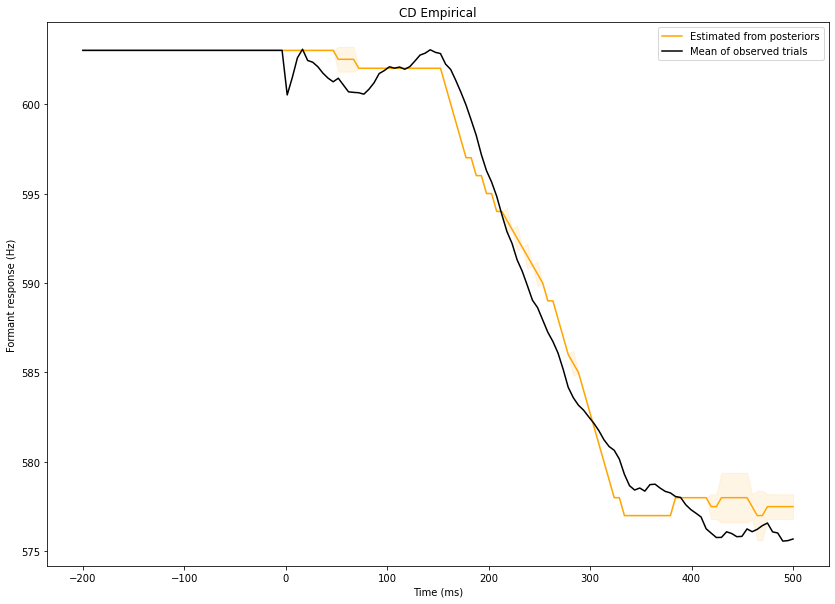

In [57]:
posterior_modes_C = stats.mode(samples_cereb,0)
posterior_modes_C = torch.from_numpy(posterior_modes_C[0][0])
print(f'poster modes {posterior_modes_C}')
print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# pdb.set_trace()

# posterior_modes_HC_manual_test = posterior_modes_HC.detach().clone()
# posterior_modes_HC_manual_test[-1] = 8
# posterior_modes_HC_manual_test[5] = posterior_modes_HC[5] * 100

all_simulated_formant = np.array([])
for ii in range(2):
    simulated_formant = FACTS(posterior_modes_C)
#     simulated_formant_manual_test = FACTS(posterior_modes_HC_manual_test)
#     pdb.set_trace()
    if ii == 0:
        all_simulated_formant = simulated_formant
    else:
        all_simulated_formant = np.vstack((all_simulated_formant, simulated_formant))
    
    
# # Plot data
x_time = np.linspace(-200,500, num=140)

mean_formants = np.mean(all_simulated_formant, axis=0)
plt.figure(figsize=(14,10))
plt.plot(x_time, mean_formants, 'orange' ,label='Estimated from posteriors')
ci = (1.96 * np.std(all_simulated_formant,axis=0)/np.sqrt(all_simulated_formant.shape[0]))
plt.fill_between(x_time, (mean_formants-ci), (mean_formants+ci), color='orange', alpha=.1)

plt.plot(x_time, cereb_mean_synth, 'k',label='Mean of observed trials')
#     plt.plot(x_time, simulated_formant_manual_test[40:140], 'red',label='Manual test')
#     plt.axvline(x = 0, color = 'grey', ls=':')
plt.legend()

plt.xlabel('Time (ms)')
plt.ylabel('Formant response (Hz)')
plt.title('CD Empirical')

## Now plot voilin plots

### Make a dataframe for easy violin plot

In [58]:
# Iterate across labels and add these to the dataframe
# for ii in range(len(labels)):
#     this_column_name = labels[ii]
#     this_column_values_cereb = samples_cereb[ii,:]
#     this_column_values_HC = samples_healthy[ii,:]
    
#     this_column_lables_cereb = ["CD"] * len(this_column_values_cereb)
#     this_column_labels_HC =  ["HC"] * len(this_column_values_HC)

In [59]:
# display(px4)
# print(np.mean(px4[px4['Group']=='CD']['value']))

In [60]:
# Mann-Whitney U test
# from numpy.random import seed
# from numpy.random import randn
# from scipy.stats import mannwhitneyu

# px3 = pd.melt(px_testFACTS, id_vars=['Group'])
# display(px3)

# print(posterior_modes_FACTS)
# for ii, label in enumerate(labels):
#     plt.figure()
#     px4 = px3[px3['variable']==label]
#     ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['TestFACTS'])
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#     plt.ylabel('Parameter Value')
#     plt.xlabel('Parameter')
    
#     ax.hlines(y=original_theta[ii], xmin=-0.5, xmax=0.5, linewidth=2, color='r')
    
    # Calculate Non-parametric diff
#     CD_data = px4[px4['Group']=='CD']['value']
#     HC_data = px4[px4['Group']=='HC']['value']
#     stat, p = mannwhitneyu(CD_data, HC_data)
    
    # Calculate glass's effects size
#     mean1 = np.mean(CD_data)
#     mean2 =  np.mean(HC_data)
#     std_hc = np.std(px4[px4['Group']=='HC']['value'])
#     glass_D = (mean1-mean2) / std_hc
    
#     plt.title(f'Whitney p-val {p:.4g} \nGlass effect size {glass_D:.2f}')

Interpret Glass effect size
https://www.uv.es/~friasnav/EffectSizeBecker.pdf

Group         variable     value
0       CD  Aud Noise Scale 0.0004619
1       CD  Aud Noise Scale 0.0005601
2       CD  Aud Noise Scale 0.0005122
3       CD  Aud Noise Scale 0.0005909
4       CD  Aud Noise Scale 0.0004603
...    ...              ...       ...
5995    HC       cc_minimum 7.5903001
5996    HC       cc_minimum 7.6022105
5997    HC       cc_minimum 7.8370180
5998    HC       cc_minimum 7.5499282
5999    HC       cc_minimum 7.5072036

[6000 rows x 3 columns]

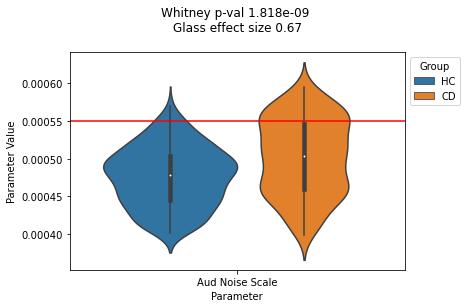

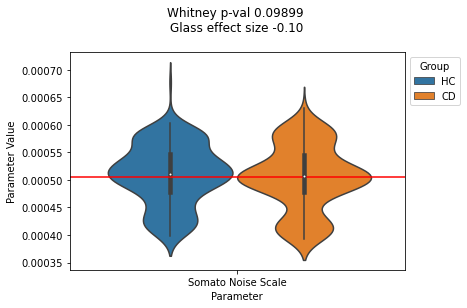

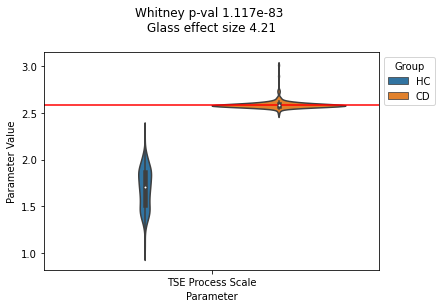

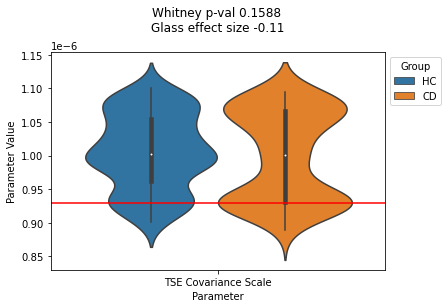

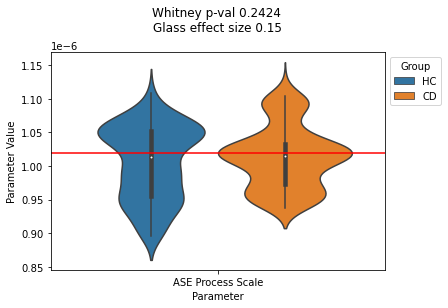

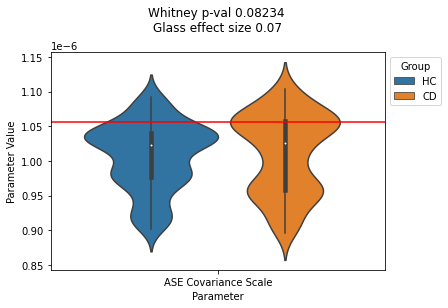

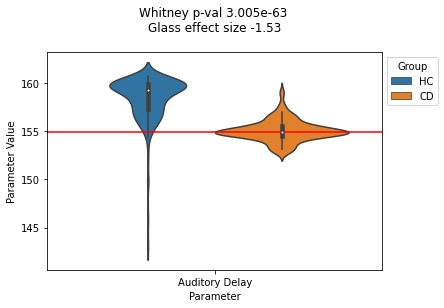

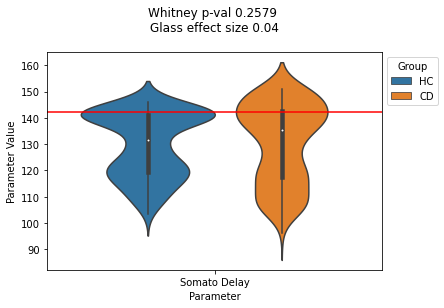

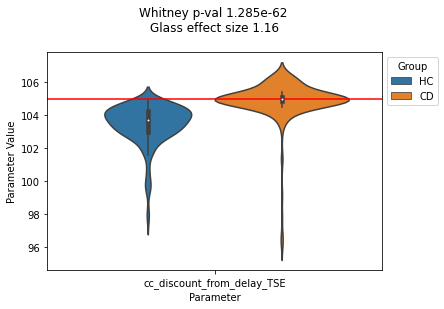

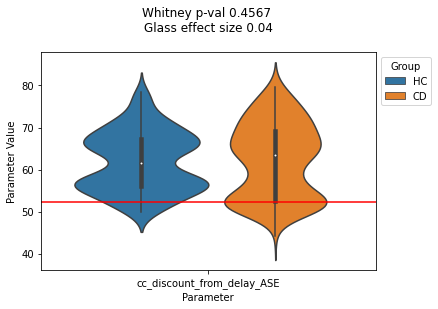

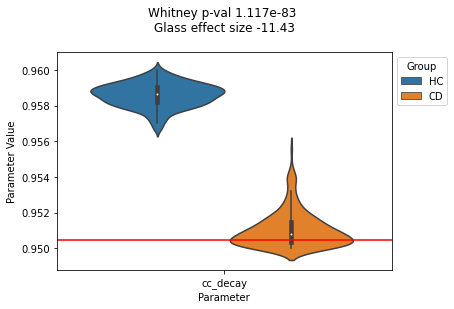

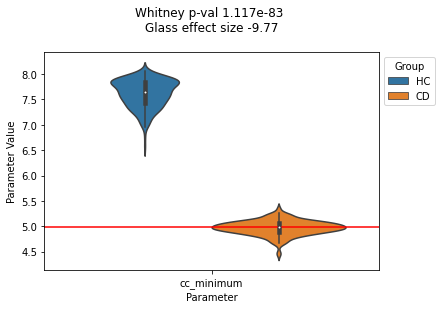

In [61]:
# Mann-Whitney U test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

px3 = pd.melt(px2, id_vars=['Group'])
display(px3)

for label in labels:
    #plt.figure()
    px4 = px3[px3['variable']==label]
    
    # Calculate Non-parametric diff
    CD_data = px4[px4['Group']=='CD']['value']
    HC_data = px4[px4['Group']=='HC']['value']
    stat, p = mannwhitneyu(CD_data, HC_data)
    
    # Calculate glass's effects size
    mean1 = np.mean(CD_data)
    mean2 =  np.mean(HC_data)
    std_hc = np.std(px4[px4['Group']=='HC']['value'])
    glass_D = (mean1-mean2) / std_hc
    
    # Get the mode of CD
#     CD_mode = np.median(CD_data)
#     display(CD_mode)
#     perm_pval = permutation_test(HC_data, CD_data, 100)
    # Calculate the KDE
    kde = stats.gaussian_kde(CD_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(CD_data.min(), CD_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    CD_mode = x[np.argmax(y)]
    
    plt.figure()
    ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['HC','CD'])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = CD_mode, color = 'r', linestyle = '-') 
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter')
    
    #Calculate boostrap
    plt.title(f'Whitney p-val {p:.4g} \nGlass effect size {glass_D:.2f}\n')
    
    
# plt.xticks(range(0,9), labels, rotation='vertical')
# plt.ylabel('Parameter Value')
# plt.xlabel('Parameter')

# Instead of Amortized, lets try Multi-round SNPE

# Multi-round on CD

In [76]:
from sbi.inference import SNPE, simulate_for_sbi
# Load posterior
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl')
print(obj)
posterior_HC_amort = obj[0]

# Load inference
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl')
print(obj)
inference = obj[0]

[DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>]


In [63]:
# torch.save(this_theta, 'sbi-logs/multiSNPE/theta1.pt')
# torch.save(this_x_r, 'sbi-logs/multiSNPE/x1.pt')

# test1 = torch.load('sbi-logs/multiSNPE/theta1.pt')
# test2 = torch.load('sbi-logs/multiSNPE/x1.pt')

# print(test1.shape)
# print(test2.shape)

In [64]:
# If you get errors about Infs or NaNs: https://github.com/sbi-dev/sbi/issues/669
num_rounds = 2
num_sims = 500
posteriors_CD = []
x_o = torch.from_numpy(cereb_mean_synth)
# x_o = all_x_ds[indices[0:1],:]
proposal = posterior.set_default_x(x_o)

for _ in range(num_rounds):
    this_theta, this_x = simulate_for_sbi(FACTS, proposal, num_simulations=num_sims)
    this_x = this_x.view(num_sims, 140).float()
    # proposal2 = posterior.set_default_x(x_o)
    density_estimator_multi = inference.append_simulations(
        this_theta, this_x, proposal=proposal
    #     all_theta, all_x_ds, proposal=proposal
    ).train(show_train_summary=True, training_batch_size=32, 
            discard_prior_samples=True, use_combined_loss=True)
    posterior_multi_CD = inference.build_posterior(density_estimator_multi)
    posteriors_CD.append(posterior_multi_CD)
    proposal = posteriors_CD.set_default_x(x_o)

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 26
        Best validation performance: -0.5278
        -------------------------
        


In [65]:
posterior_multi_CD2 = inference.build_posterior(density_estimator_multi)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    21 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


poster modes tensor([3.965190844610333442687988281250e-04,
        3.938472364097833633422851562500e-04,
        2.386849403381347656250000000000e+00,
        8.725396014597208704799413681030e-07,
        9.078715947907767258584499359131e-07,
        8.947101264311640989035367965698e-07,
        1.529881744384765625000000000000e+02,
        9.676334381103515625000000000000e+01,
        1.045768356323242187500000000000e+02,
        4.985508728027343750000000000000e+01,
        9.500143527984619140625000000000e-01,
        4.516973018646240234375000000000e+00])
% difference in parameter tensors tensor([[-2.050919234752655029296875000000e-01,
         -2.849798798561096191406250000000e-01,
          1.174959018826484680175781250000e-01,
         -1.764448434114456176757812500000e-01,
         -9.577845782041549682617187500000e-02,
         -1.693896353244781494140625000000e-01,
         -1.334327273070812225341796875000e-02,
         -2.609615921974182128906250000000e-01,
          4.5269

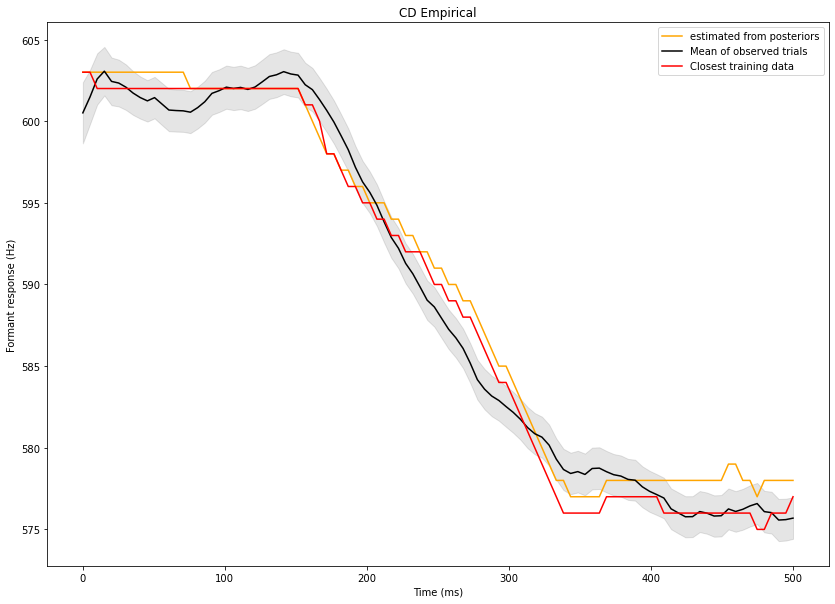

In [66]:
# samples_cereb_multi = posterior.sample((sample_size,), x=smoothed_cereb)
samples_cereb_multi = posterior_multi_CD2.sample((100,), x=cereb_mean_synth)

posterior_modes_C = stats.mode(samples_cereb_multi,0)
posterior_modes_C = torch.from_numpy(posterior_modes_C[0][0])

# posterior_modes_C = get_modes(samples_cereb_multi)
# posterior_modes_C = np.median(samples_cereb_multi, axis=0)
# posterior_modes_C = np.average(samples_cereb_multi, axis=0)
# posterior_modes_C = torch.from_numpy(posterior_modes_C)
print(f'poster modes {posterior_modes_C}')

#posterior_modes_C_manual_test = posterior_modes_C.detach().clone()
posterior_modes_CD_manual_test = torch.tensor([0.005,
            0.0005,
            4.0,
            0.0000001, 
            0.0001, 
            0.000001,
            150.0,
            100.0,
            100.8,
            55.0,
            0.955,
            6.0])


# print(f'posterior_modes_C_manual_test {posterior_modes_C_manual_test}')
posterior_modes_C2 = posterior_modes_C.clone()
posterior_modes_C2[3] = posterior_modes_CD_manual_test[3]

best_theta = all_theta[indices[0:1],:]
# Sort by sum
for ii in range(1):
    #pdb.set_trace()
    simulated_formant_C = FACTS(posterior_modes_C)
#     simulated_formant_manual_test = FACTS(posterior_modes_CD_manual_test)
    
    x_time = np.linspace(0,500, num=100)

    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_C[40:140], 'orange', label='estimated from posteriors')
    plt.plot(x_time, cereb_mean_synth[40:140], 'k',label='Mean of observed trials')
    plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='k', alpha=.1)
    plt.plot(x_time, all_x_ds[indices[0:1],40:].T, label='Closest training data', color='red')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('CD Empirical')
    
print(f'% difference in parameter tensors {(posterior_modes_C - best_theta)/best_theta}')


In [67]:
# this_theta7, this_x7 = simulate_for_sbi(FACTS, proposal, num_simulations=num_sims)
# this_x7 = this_x7.view(num_sims, 140).float()

# # Save the data
# torch.save(this_theta7, 'sbi-logs/multiSNPE/theta6_CD.pt')
# torch.save(this_x7, 'sbi-logs/multiSNPE/x6_CD.pt')


# posterior_multi = inference.build_posterior(density_estimator_multi_HC)
# posteriors_HC.append(posterior_multi)
# proposal_multi = posterior_multi.set_default_x(x_o)

In [68]:
# torch.save(this_theta, 'sbi-logs/multiSNPE/theta.pt')
# torch.save(this_x2, 'sbi-logs/multiSNPE/x.pt')

In [69]:
# Aggregate the training data
# all_files = os.listdir('./sbi-logs/multiSNPE')
# selected_files_theta = [x for x in all_files if 'theta' in x ]
# selected_files_x = [x for x in all_files if 'x' in x]


# # Iterate through list
# all_multi_theta, all_multi_x = torch.tensor(np.array([]), dtype=torch.float32), torch.tensor(np.array([]), dtype=torch.float32)
# for i, file_string in enumerate(selected_files_x):
# #     file = open(f'./sbi-logs/multiSNPE/{file_string}', 'rb')
#     this_multi_theta = torch.load(f'./sbi-logs/multiSNPE/{selected_files_theta[i]}')
#     this_multi_x = torch.load(f'./sbi-logs/multiSNPE/{selected_files_x[i]}')

#     # Append 
#     all_multi_theta = torch.cat((all_multi_theta, this_multi_theta))
#     all_multi_x = torch.cat((all_multi_x, this_multi_x))
  
# print(all_multi_theta.shape)
# print(all_multi_x.shape)

In [70]:
# sum(np.isnan(all_multi_x).any(axis=0))

In [71]:
# plt.plot(all_multi_x.T)

In [72]:
# np.save('sbi-logs/multiSNPE/healthy_mean_synth.npy',healthy_mean_synth)
# np.save('./sbi-logs/multiSNPE/cereb_mean_synth.npy',cereb_mean_synth)

In [73]:
# proposal2 = posterior.set_default_x(x_o)
# density_estimator_multi_HC = inference.append_simulations(
#     all_multi_theta, all_multi_x, proposal=proposal2
# #     all_theta, all_x_ds, proposal=proposal
# ).train(show_train_summary=True, training_batch_size=32)

# Multi-round on HC

In [74]:
# Load posterior
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_posterior_{all_theta.size()[0]}_okay.pkl')
print(obj)
posterior_HC_amort = obj[0]

# Load inference
obj = pd.read_pickle(f'./sbi_resources/ModelC_auditory_soma_noise_TSE_ASE_Delay_inference_{all_theta.size()[0]}_okay.pkl')
print(obj)
inference = obj[0]


[DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>]


In [83]:
num_rounds = 1
num_sims = 1000
posteriors_HC = []
x_o = torch.from_numpy(healthy_mean_synth)
proposal = posterior_HC_amort.set_default_x(x_o)

for _ in range(num_rounds):
    this_theta, this_x = simulate_for_sbi(FACTS, proposal, num_simulations=num_sims)
    this_x = this_x.view(num_sims, 140).float()
    density_estimator_multi_HC = inference.append_simulations(
    this_theta, this_x, proposal=proposal
    ).train(show_train_summary=True, training_batch_size=32, 
         discard_prior_samples=True, use_combined_loss=True)
    posterior_multi_HC = inference.build_posterior(density_estimator_multi_HC)
    posteriors_HC.append(posterior_multi_HC)
    proposal = posterior_multi_HC.set_default_x(x_o)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 97 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 97
        Best validation performance: -0.2129
        -------------------------
        


Drawing 250 posterior samples:   0%|          | 0/250 [00:00<?, ?it/s]

poster modes tensor([4.039187333546578884124755859375e-04,
        3.376504173502326011657714843750e-04,
        8.880504965782165527343750000000e-02,
        8.353180191988940350711345672607e-07,
        9.003817922348389402031898498535e-07,
        8.693370432411029469221830368042e-07,
        1.564560699462890625000000000000e+02,
        9.690223693847656250000000000000e+01,
        1.061702728271484375000000000000e+02,
        3.856383132934570312500000000000e+01,
        9.554644227027893066406250000000e-01,
        6.812772750854492187500000000000e+00])


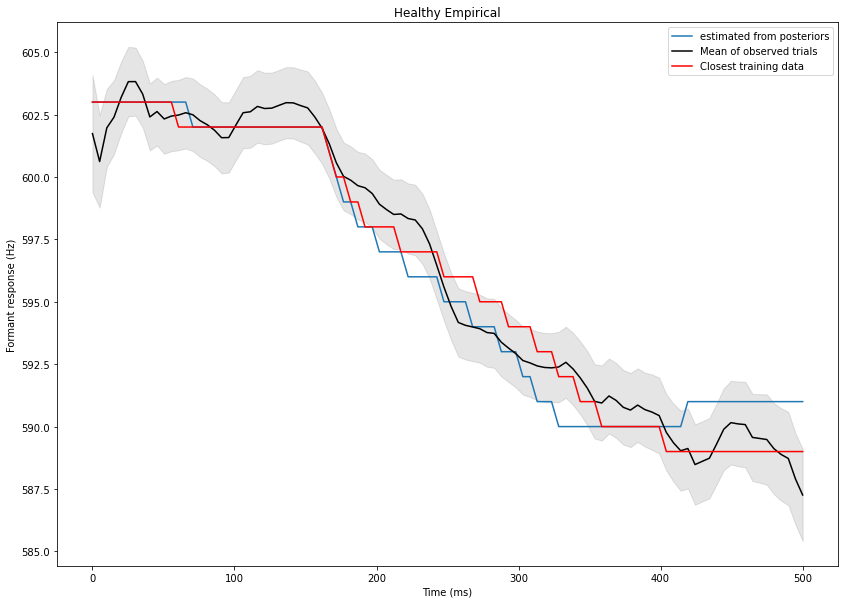

In [84]:
samples_multi_HC = posterior_multi_HC.sample((250,), x=healthy_mean_synth)

posterior_modes_HC = stats.mode(samples_multi_HC,0)
posterior_modes_HC = torch.from_numpy(posterior_modes_HC[0][0])

# posterior_modes_HC = get_modes(samples_multi_HC)
# posterior_modes_HC = np.average(samples_multi_HC, axis=0)
# posterior_modes_HC = np.median(samples_multi_HC, axis=0)
# posterior_modes_HC = torch.from_numpy(samples_multi_HC)
print(f'poster modes {posterior_modes_HC}')
# print(f'original theta {0.005, 0.005, 0.01, 0.1, 0.0000001, 0.0000001, 100, 50, 3}')
# pdb.set_trace()


for ii in range(1):
    simulated_formant_H = FACTS(posterior_modes_HC)

    # Plot data
    x_time = np.linspace(0,500, num=100)
    plt.figure(figsize=(14,10))
    plt.plot(x_time, simulated_formant_H[40:140], label='estimated from posteriors')

    plt.plot(x_time, healthy_mean_synth[40:140], 'k',label='Mean of observed trials')
    plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='k', alpha=.1)
    plt.plot(x_time, all_x_ds[indicesHC[0:1],40:].T, color='red', label='Closest training data')
    plt.legend()

    plt.xlabel('Time (ms)')
    plt.ylabel('Formant response (Hz)')
    plt.title('Healthy Empirical')

# print(f'difference of parameter values = {posterior_modes_HC - posterior_modes_HC_manual_test}')

Text(0.5, 1.0, 'Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

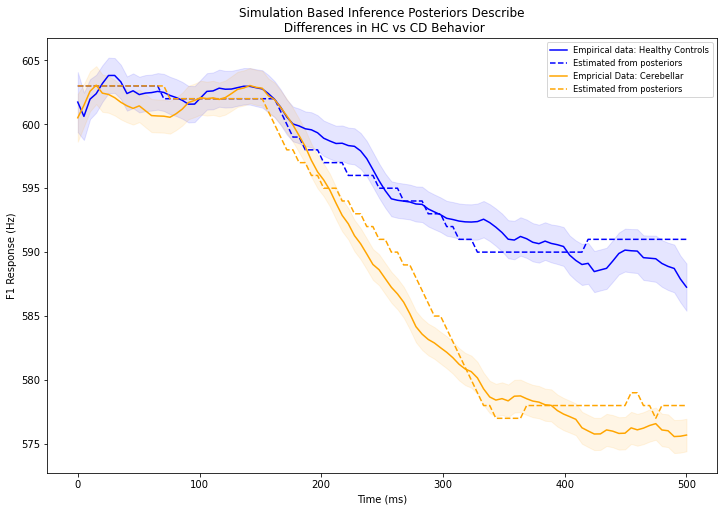

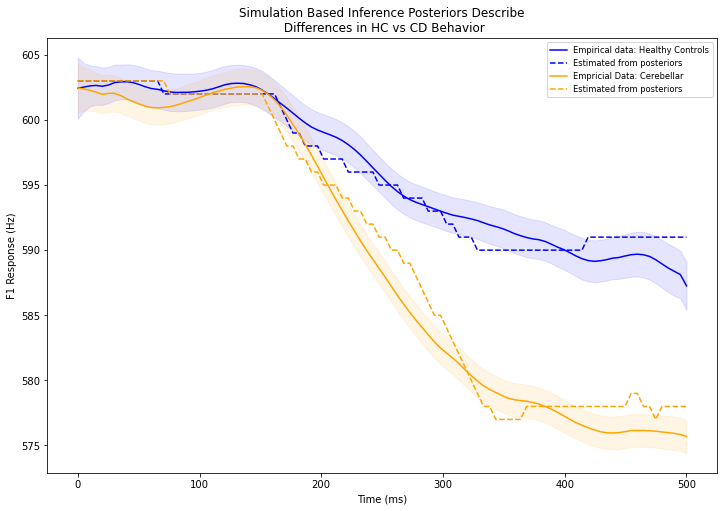

In [85]:
x_time = np.linspace(0,500, num=100)

plt.figure(figsize=(12,8))
plt.plot(x_time, healthy_mean_synth[40:140], 'blue',label='Empirical data: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (healthy_mean_synth[40:140]-healthy_ci_ds), (healthy_mean_synth[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, cereb_mean_synth[40:140], 'orange',label='Empricial Data: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (cereb_mean_synth[40:140]-cereb_ci_ds), (cereb_mean_synth[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='small')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

# Plot smoothed
# smoothed_cereb = smooth_np_convolve(cereb_mean_synth, 9)
# smoothed_healthy = smooth_np_convolve(healthy_mean_synth, 9)
plt.figure(figsize=(12,8))
plt.plot(x_time, smoothed_healthy[40:140], 'blue',label='Empirical data: Healthy Controls')
plt.plot(x_time, simulated_formant_H[40:140], 'blue', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (smoothed_healthy[40:140]-healthy_ci_ds), (smoothed_healthy[40:140]+healthy_ci_ds), color='blue', alpha=.1)


plt.plot(x_time, smoothed_cereb[40:140], 'orange',label='Empricial Data: Cerebellar')
plt.plot(x_time, simulated_formant_C[40:140], 'orange', linestyle='--' ,label='Estimated from posteriors')
plt.fill_between(x_time, (smoothed_cereb[40:140]-cereb_ci_ds), (smoothed_cereb[40:140]+cereb_ci_ds), color='orange', alpha=.1)

plt.xlabel('Time (ms)')
plt.ylabel('F1 Response (Hz)')

plt.legend(fontsize='small')
plt.title('Simulation Based Inference Posteriors Describe\n Differences in HC vs CD Behavior')

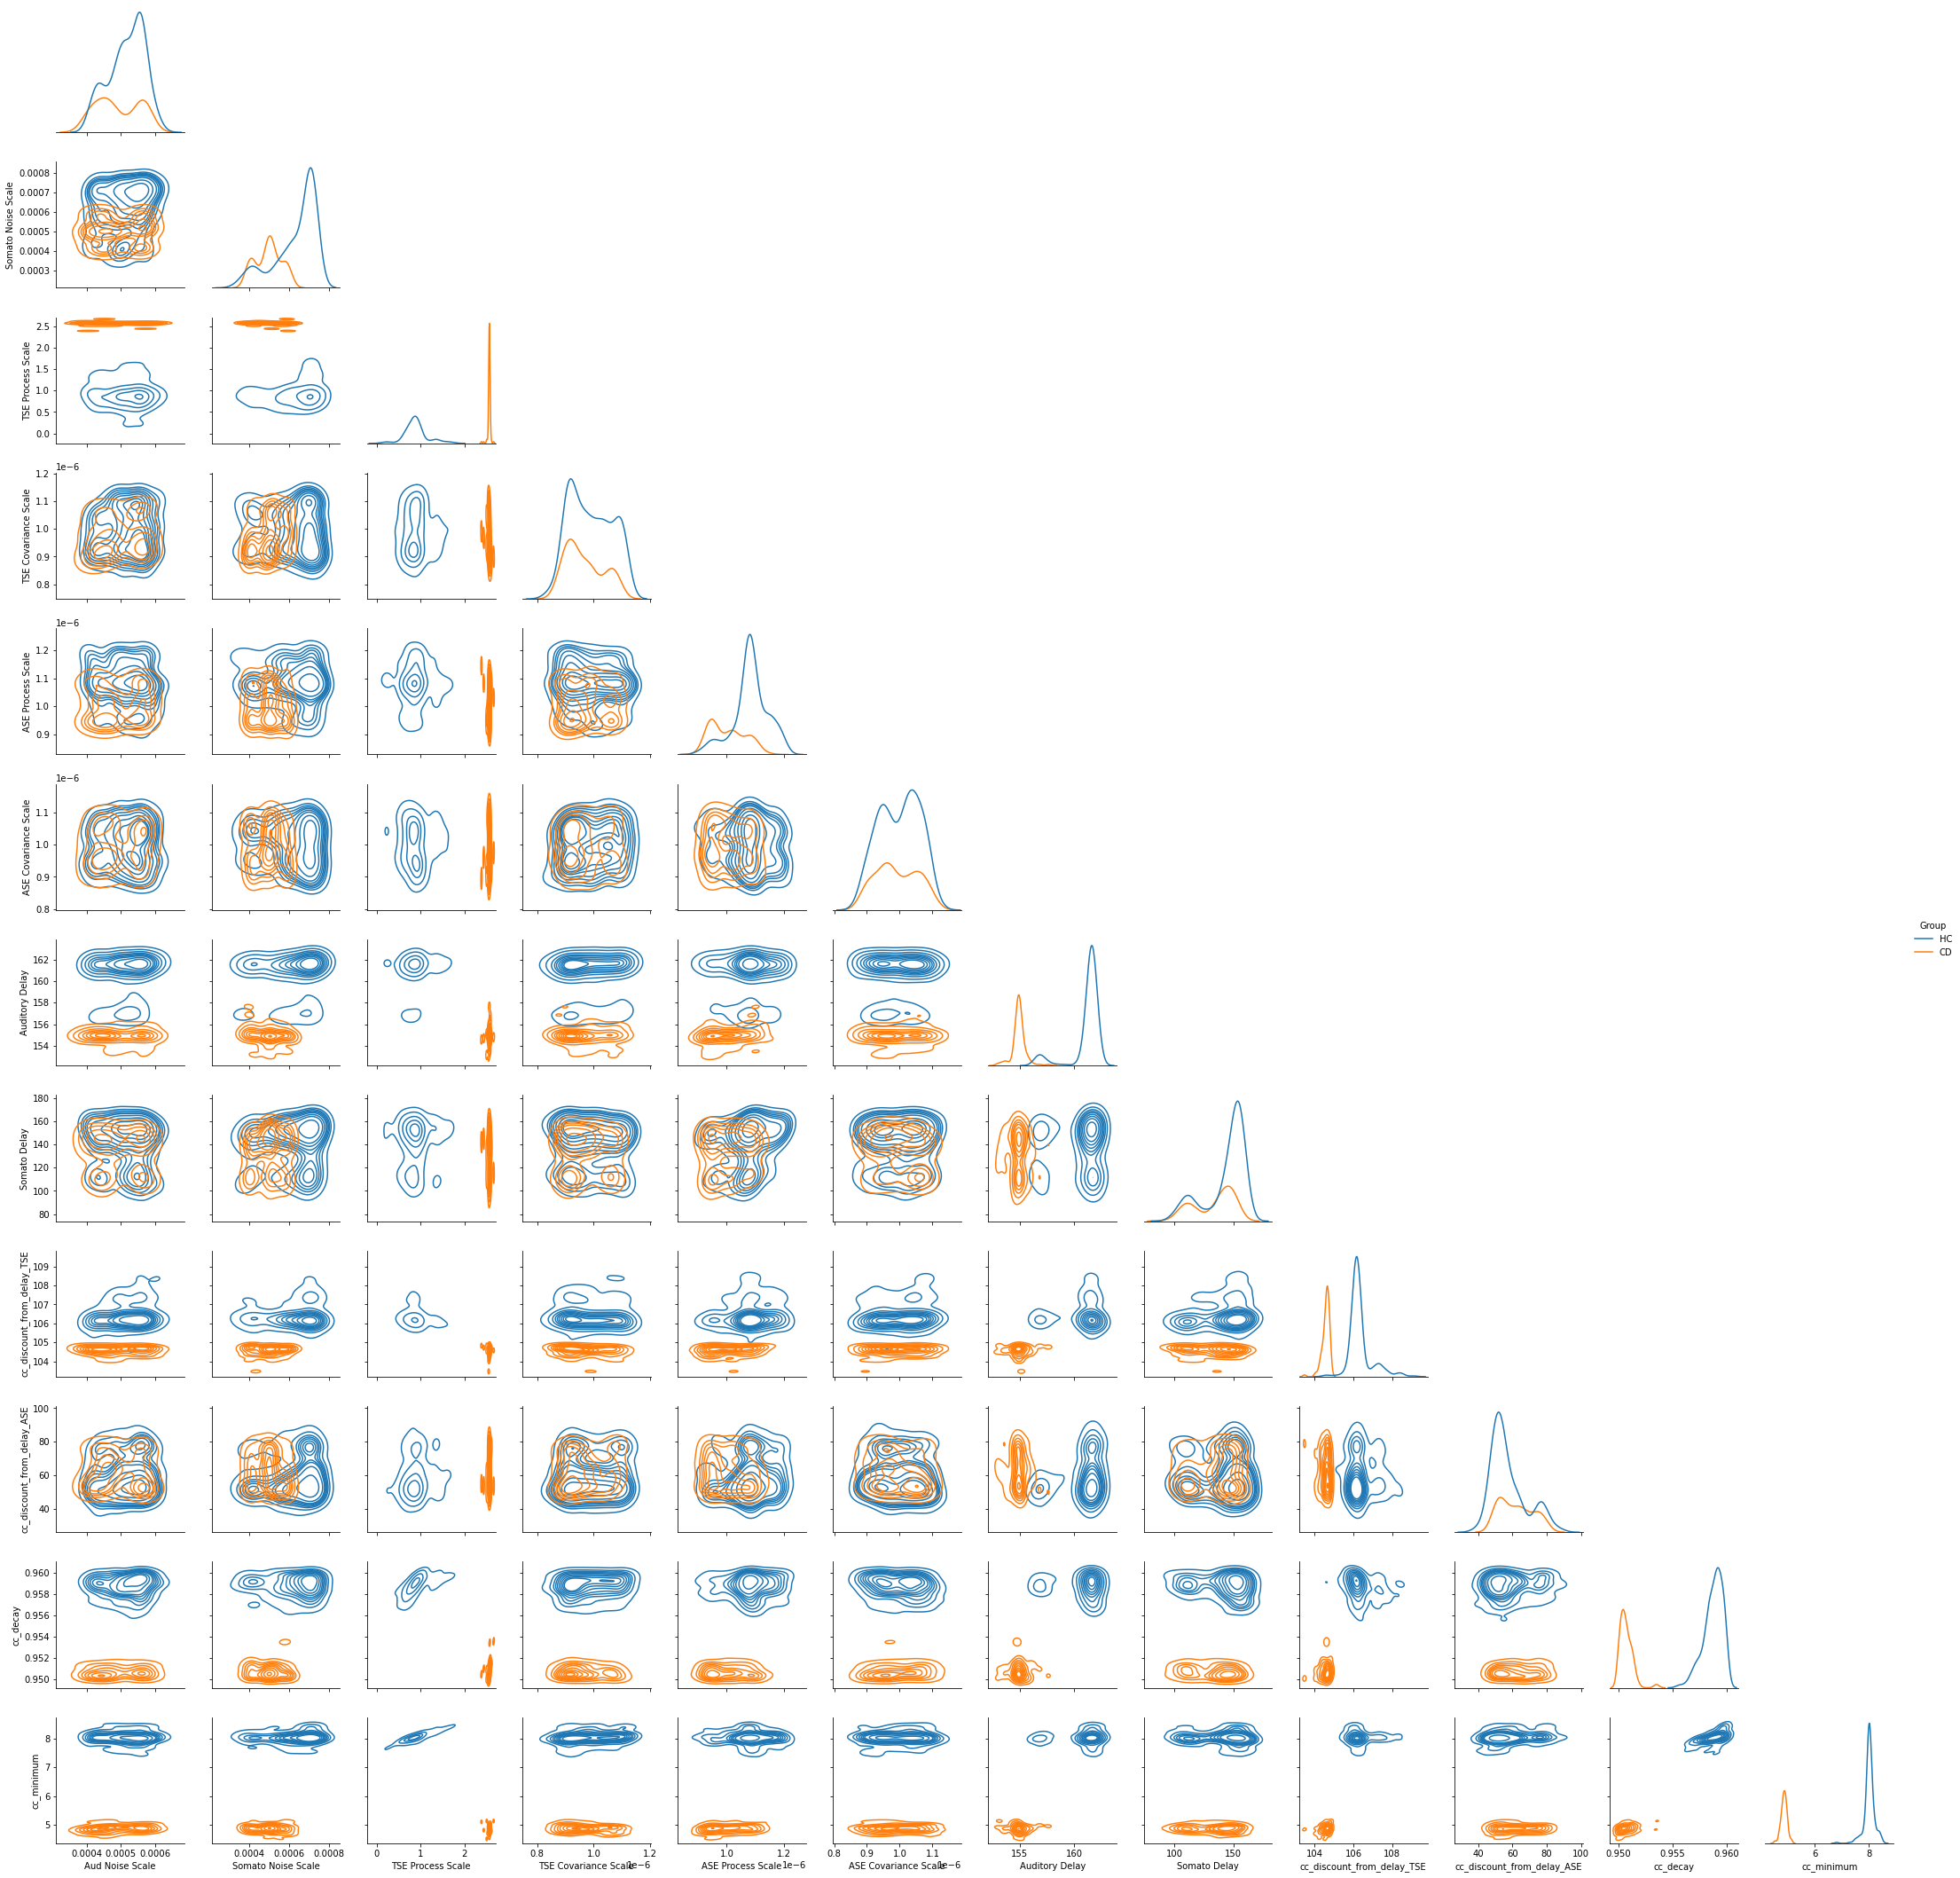

In [86]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Append Healthy data
px_healthy = pd.DataFrame(samples_multi_HC).astype("float")
px_healthy.set_axis(labels, axis="columns", inplace=True)
px_healthy["Group"] = "HC"

# Append CD
px = pd.DataFrame(samples_cereb_multi).astype("float")
px.set_axis(labels, axis="columns", inplace=True)
px["Group"] = "CD"

# px2 = px_testFACTS
px2 = pd.concat([px,px_healthy], ignore_index=True)

g = sns.PairGrid(px2, diag_sharey=False, corner=True, hue="Group", hue_order=['HC','CD'])

g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.add_legend()

Group         variable     value
0       CD  Aud Noise Scale 0.0005161
1       CD  Aud Noise Scale 0.0004619
2       CD  Aud Noise Scale 0.0004553
3       CD  Aud Noise Scale 0.0005667
4       CD  Aud Noise Scale 0.0004210
...    ...              ...       ...
4195    HC       cc_minimum 7.7866025
4196    HC       cc_minimum 7.9993095
4197    HC       cc_minimum 8.1516294
4198    HC       cc_minimum 7.7918415
4199    HC       cc_minimum 7.8448906

[4200 rows x 3 columns]

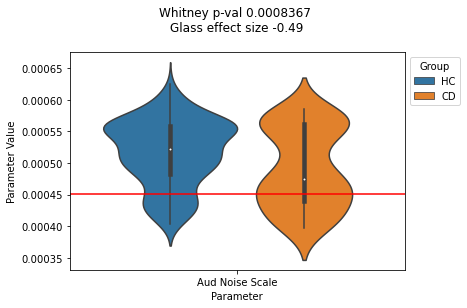

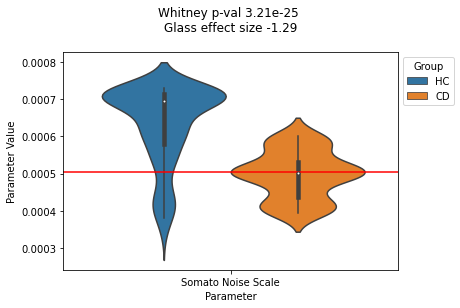

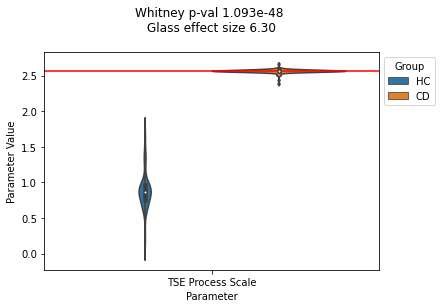

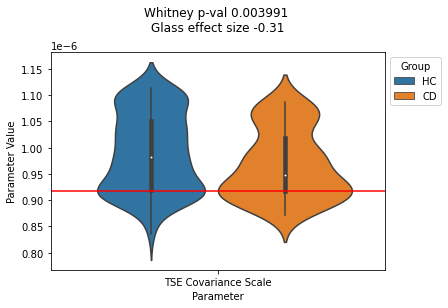

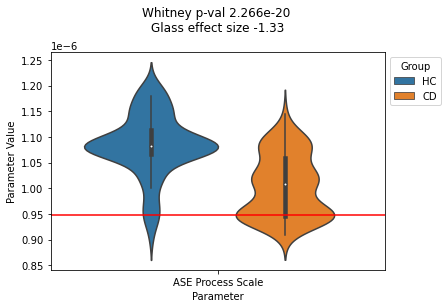

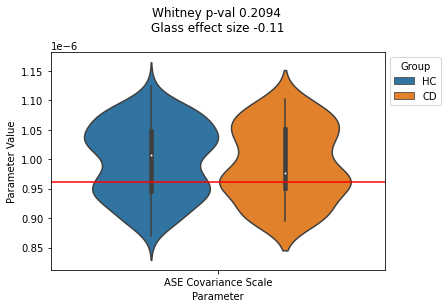

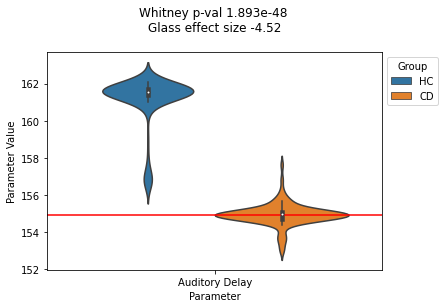

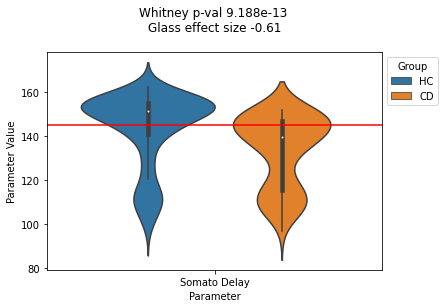

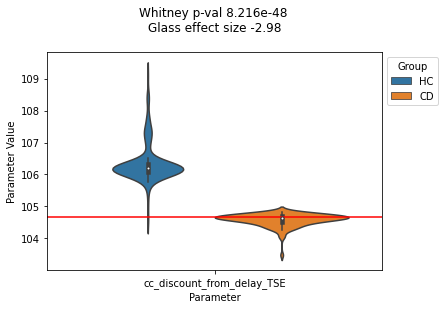

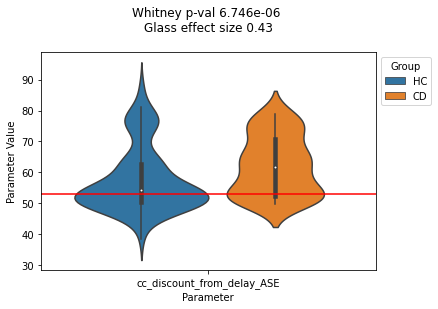

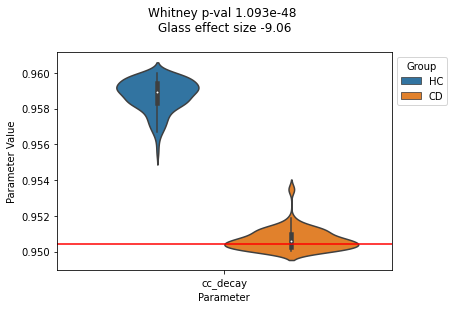

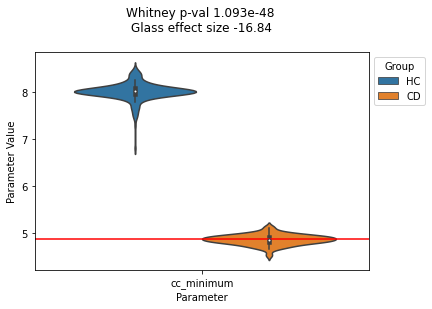

In [87]:
px3 = pd.melt(px2, id_vars=['Group'])
display(px3)

for label in labels:
    #plt.figure()
    px4 = px3[px3['variable']==label]
    
    # Calculate Non-parametric diff
    CD_data = px4[px4['Group']=='CD']['value']
    HC_data = px4[px4['Group']=='HC']['value']
    stat, p = mannwhitneyu(CD_data, HC_data)
    
    # Calculate glass's effects size
    mean1 = np.mean(CD_data)
    mean2 =  np.mean(HC_data)
    std_hc = np.std(px4[px4['Group']=='HC']['value'])
    glass_D = (mean1-mean2) / std_hc
    
    # Get the mode of CD
#     CD_mode = np.median(CD_data)
#     display(CD_mode)
#     perm_pval = permutation_test(HC_data, CD_data, 100)
    # Calculate the KDE
    kde = stats.gaussian_kde(CD_data)
    # Define a range of values over which to evaluate the KDE
    x = np.linspace(CD_data.min(), CD_data.max(), 1000)
    # Evaluate the KDE over the range of values
    y = kde.evaluate(x)

    # Find the x value where the KDE is at its maximum
    CD_mode = x[np.argmax(y)]
    
    plt.figure()
    ax = sns.violinplot(px4, x="variable", y="value", hue="Group",figsize=(20,20), hue_order=['HC','CD'])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.axhline(y = CD_mode, color = 'r', linestyle = '-') 
    plt.ylabel('Parameter Value')
    plt.xlabel('Parameter')
    
    #Calculate boostrap
    plt.title(f'Whitney p-val {p:.4g} \nGlass effect size {glass_D:.2f}\n')
    
    